In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [3]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = 50 #math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = 150 #CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [4]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [5]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed127_MDon"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff"]

# RUNS_MD = ["seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
# RUNS_MD_NO = ["seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# RUNS_MD = ["seed127_MDon", "seed88_MDon", "seed177_MDon_10", "seed83_MDon_10"]
# RUNS_MD_NO = ["seed127_MDoff", "seed88_MDoff", "seed177_MDoff_10", "seed83_MDon_10"]

# RUNS_MD = ["seed88_MDon"]
# RUNS_MD_NO = ["seed88_MDoff"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

In [5]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]


scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 5
    
    (rPFC_trials, task_input, v1v2_values, wPFC_output) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
        
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)

Optimization terminated successfully.
         Current function value: 0.023760
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.227986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.602461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692397
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.573182
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.068691
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660271
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))



         Current function value: 0.209578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040146
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.631578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.032362
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.179092
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.378593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.105192
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.065569
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.132852
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.327976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690828
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.047897
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020318
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.011389
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.016583
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.107573
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.522409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.0334

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111673
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.107752
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.347772
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.174901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.161630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.304229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.112356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046059
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.310938
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318977
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.233191
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012698
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.558012
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018171
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.662141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074207
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.029068
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689809
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.264490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062744
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.448401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493101
         Iterations 10
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070912
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.298018
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.096537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.432476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682863
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.148565


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.131879
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.240595
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066112
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.118162
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081921
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.267673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.313680
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231638
         Iterations 11
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.635069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256924
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133154
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040618
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.038376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.662414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.004835
         Iterations 39
Optimization terminated successfully.
         Current function value: 0.074330
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.46521

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.716163
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.226051
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692055
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.678799
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183497
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.220155
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016939
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.268026
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057392
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.569037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050087
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146673
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055658
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132979
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.211076
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015257
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.690931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.013008
         Iterations 15
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053452
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139073
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691184
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022344
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.015122
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.113323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.04598

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.430884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.097497
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.045539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.081849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.265062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.230443
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136815
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102904
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134807
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.135146
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.275058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.324227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.563494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045648
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032201


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.161926
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676570
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.501345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.673326
         Iterations 6
         Current function value: 0.687721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673816
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047446
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.241442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690392
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243481
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006959
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.079956
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087657
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097924
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043283
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.471708
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669295
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.540128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.296437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.105367
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.188824
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.116104
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.161951
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327421
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.338342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036246
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.617801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.236040
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686505
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.371571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.152258
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.502035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.296861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.221711
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045930
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.597178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387415
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692578
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078073
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.350756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241960
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014980
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692227
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368562
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639870
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022235
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692536
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.594251
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124418
         Iterations 9
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027724
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.207435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039970
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065633
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.263123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.447664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.112624
         Iterations 10
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.297571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024966
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.554335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.206890
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.016618
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692461
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.108742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.228702
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.122659
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675720
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646154
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.097982
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.237371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.212178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.276677
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013061
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.029050
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.381781
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024844
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.350711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.456256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.234882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.185313

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157388
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.306582
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.113503
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058278
         Iterations 12
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073372
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.055780
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020359
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.528857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.193177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.153332
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.124291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681253
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.195774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.567865
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079021
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077556
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686261
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.572956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.144186
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.589546
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686237
         Iterations 5
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691200
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.131324
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.661492
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662999
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162850
         Iterations 8
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691652
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176303
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678970
         Iterations 5
         Current function value: 0.681137
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692581
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.061205
         Iterations 43
         Current function value: 0.424319
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194158
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.283394
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021568
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.689515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681378
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.408830
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689198
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174260
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.202403
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.531311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.629788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052585
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.637035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.035652
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.449608

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.537884
         Iterations 6
         Current function value: 0.681137
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.224302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028132
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589605
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.189464
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.060247
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.237403
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042371
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022425
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030495
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.559407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021444
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.688168
         Iterations: 50
         Current function value: 0.772701
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044221
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.462403
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.449160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.162246
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.541142
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.109733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.310779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038913
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.595004
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.473585
         Iterations 6
         Current function value: 0.681137
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140172
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.092346
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011075
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.107350
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074264
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020236
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.688914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.17166

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.092822
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091159
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074869
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691056
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.658218
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039841
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010942
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.485859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606557
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027086
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.198898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013311
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.034624
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.665228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.297653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.561483
         Iterations 6
         Current function value: 0.647559
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.676703
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.082474
         Iterations 9
         Current function value: 0.020047
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.627574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553294
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.046124
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692015
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.360973
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675187
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282559
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660436
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076323
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.158611
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.354136
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043781
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012371
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.108758
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.300910
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264719
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012957
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.686165
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.052031
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264215
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.532001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.289975
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057653
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071546
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658310
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.170106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045882
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.005898
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024328
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.039279
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691899
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024262
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.054306
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113011
         Iterations 9
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.154425
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.484213
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023559
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333647
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011104
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.184753
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019491
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122593
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163583
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.379256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216371
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.100812
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341034
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026011
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.280148
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016156
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.147505
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014140
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.397680
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145305
         Iterations 9
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067430
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201263
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021896
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090146
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.341604
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094965
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.491080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206358
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.320649
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182121
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.076040
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150812
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009998
         Iterations 16
         Current function value: 0.941937
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005817
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.029902
         Iterations 10
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688890
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016887
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079331
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.445321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.069337
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153760
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639982
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.040265
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.289550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138956
         Iterations 9
         Current function value: 0.000000
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.240049
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043805
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042169
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.680149
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008327
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.024041
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007450
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019699
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.088835
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072649
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.624604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.250477
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.203127
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145555
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.548607
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353220
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026027
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.091787
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692177
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287759
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.577006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.021089
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032032
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.012734
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300352
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.529414
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064325
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.379427
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283858
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.408255
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.048661
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133333
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005205
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.210323
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628852
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054434
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.258712
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145568
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.677192
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018517
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693126
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.346513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668354
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678656
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.519706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014418
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.294153
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287159
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693103
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.029779
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011121
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.256786
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.135284
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.433727
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078122
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.264005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.080716
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074854
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.298396
         Iterations 8
         Current function value: 0.502127
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634372
         Iterations 5
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095562
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011284
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692305
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.122507
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247672
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.522190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023324
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.296365
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.637714
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.252795
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117785
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.171844
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.663090
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.028238
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021737
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.445459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684296
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132163
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462805
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022088
         Iterations 12
         Current function value: 0.174783
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634914
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688464
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585024
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019325
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.210150
         Iterations 9
         Current function value: 0.000006
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035445
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.192678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023430
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029450
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685449
         Iterations 37
Optimization terminated successfully.
         Current function value: 0.077424
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.153873
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033454
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095347
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.101751
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626012
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000029
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021874
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.289125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014017
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.139461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.162409
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.472574
         Iterations 7
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009615
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.573039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091455
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.116948
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039197
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.268524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025942
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.110657
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021047
         Iterations 12
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.406574
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036030
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.209894
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013429
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.152263
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539144
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050326
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339863
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046283
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.658406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.133125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.207752
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.335041
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.454174
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469261
         Iterations 21
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548572
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110034
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005284
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.048720
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.601356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654399
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.430395
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010759
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.549563
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116066
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.359077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.218032
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636589
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085306
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025336
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074781
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684965
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.035377
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631519
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240652
         Iterations 8
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.674342
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.228702
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064871
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680069
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.446988
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023321
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.138059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020160
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.682749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.037770
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.599528
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.278660
         Iterations 7
         Current function value: 0.638681
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678941
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.241183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009603
         Iterations 17
         Current function value: 0.690831
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025483
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.052264
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090032
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.306171
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692773
         Iterations 3
         Current function value: 0.679961
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184010
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170928
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.239552
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688504
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054920
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.047619
         Iterations 9
         Current function value: 0.682463
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166209
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692906
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.666374
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.625761
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.117970
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.482167
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045055
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148362
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.161005
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055295
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.056589
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.68557

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163646
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093303
         Iterations 13
         Current function value: 0.385696
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034763
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.631428
         Iterations 5
         Current function value: 0.326848
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088396
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.059497
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.685189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024836
         Iterations 11
         Current function value: 0.507351
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691929
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005652
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.675885
         Iterations 5
         Current function value: 0.679109
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687254
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.654210
         Iterations 5
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351399
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028850
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.188935
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021129
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083111
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.139914
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010391
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.194271
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309365
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.073909
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580748
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.234225
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.545271
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033119
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682110
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.596130
         Iterations 22
         Current function value: 0.020047
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692179
         Iterations 4
         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564186
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.587342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310816
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.609857
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.546482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307863
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682201
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.139042
         Iterations 9
         Current function value: 0.061297
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024221
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688933
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.204744
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018646
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243272
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027881
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017050
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.074869
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.433355
         Iterations 7
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.326683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086331
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048737
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670103
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.515136
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534582
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.035615
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.230725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070794
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.594228
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025365
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.086086
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.579304
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653316
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017100
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036214
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409932
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251394
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.639825
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100178
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116918
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034421
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.268998
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360545
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688424
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118836
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021779
         Iterations 12
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.281240
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164106
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.197964
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116287
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.033163
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.429391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692336
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.571537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100066
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013156
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.124346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084252
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059957
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007272
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.069679
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094496
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692328
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048012
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097382
         Iterations 9
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684227
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223440
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150879
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.244225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.120222
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200269
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152786
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331672
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673601
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454127
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026055
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684021
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.115436
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021654
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.656410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172004
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.107161
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040373
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.065071
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461359
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692054
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.072241
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018558
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008238
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.601688
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.096419
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087971
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.232719
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673006
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.284375
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.118845
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548428
         Iterations 6
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080258
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.019568
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.653731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034750
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028751
         Iterations 10
         Current function value: 0.030149
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026189
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672362
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414486
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054060
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.630631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.340483
         Iterations 8
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066295
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044375
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052799
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034317
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686199
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686952
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195048
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584530
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236976
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048815
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272369
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260568
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642319
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064433
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.144821
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.355604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.317628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688291
         Iterations 6
         Current function value: 0.000636
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.234710
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.533502
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.258697
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.051454
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.049716
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.075638
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068823
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683653
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.048549
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.191140
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007180
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.203890
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.275769
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.30315

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135882
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146691
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059829
         Iterations 9
         Current function value: 0.000025
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047470
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022119
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086852
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031285
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.280506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182117
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020960
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374546
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009474
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042001
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.204585
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393469
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023064
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.150038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.430697
         Iterations 7
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039333
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029811
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.185532
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.528001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430418
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.566873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269453
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016614
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335076
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.112458
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.186826
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017891
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023121
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.319425
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047804
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.668048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413404
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216071
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.100674
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146380
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.569996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.586110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186780
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032240
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.611905
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056712
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026760
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042137
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008549
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.079410
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031415
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.274641
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.440848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191382
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181628
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.023787
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014633
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.665599
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.230830
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099128
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.236447
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691839
         Iterations 4
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061915
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091602
         Iterations 9
         Current function value: 0.640730
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040486
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666592
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.251840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.077537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064740
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.281949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.156280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017132
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.588070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029755
         Iterations 11
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118871
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561509
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.197836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.119833
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.120397
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.158667
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.521173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.307627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028240
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.045271
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.648046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127233
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.238071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069846
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065197
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.175459
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141510
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.589189
         Iterations 6
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265920
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126536
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.277880
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.471011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012461
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.470427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659628
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076000
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040496
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152672
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.253080
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317954
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.123886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.190771
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021695


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 12
Optimization terminated successfully.
         Current function value: 0.308872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.294841
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116312
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119792
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020556
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.292353
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.207565
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.226678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.389020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123257
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691974
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053921
         Iterations 10
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088860
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069989
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056186
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690787
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131350
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.020177
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026501
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016666
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.408123
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023881
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.354732
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690710
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.412809
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061721
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265727
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127955
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.560401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.434140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657267
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689966
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021358
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130732
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.078559
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692090
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072662
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686605
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.107401
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681996
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082826
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015968
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.299974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.080039
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.211982
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104628
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118518
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338772
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070430
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.119181
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.407800
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015410
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.149491
         Iterations 9
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.691198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010055
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.053398
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545453
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.278773
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.664369
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027512
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.611429
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.478379
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685010
         Iterations 8
         Current function value: 0.000023
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059986
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.641342
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.230929
         Iterations 9
         Current function value: 0.020177
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135804
         Iterations 9
         Current function value: 0.373094
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.205154
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223534
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.197660
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062774
         Iterations 9
         Current function value: 0.589139
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035175
         Iterations 10
         Current function value: inf
         Iterations: 50
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692336
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.148246
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692322
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.014944
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.014336
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.264647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.635804
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065300
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.221221
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324418
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070892
         Iterations 10
         Current function value: 0.686130
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126543
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683545
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
         Current function value: 0.072959
         Iterations: 50
         Current function value: 0.170233
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.601718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314251
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635892
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.059906
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261067
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680701
         Iterations 6
         Current function value: 0.020686
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172455
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027410
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.685362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.114515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.529599
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.680257
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.073863
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.142791
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.514861
         Iterations 10
         Current function value: 0.608800
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683545
         Iterations: 50
         Current function value: 0.275721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686557
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020575
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.038534
         Iterations 10
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586240
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036631
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682884
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642679
         Iterations 8
         Current function value: 0.081999
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066296
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680430
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012190
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.491810
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692298
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.234213
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.530917
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120021
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.213708
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684761
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437084
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.248105
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.071520
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.689894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020200
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.061981
         Iterations 9
         Current function value: 0.650405
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102864
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096249
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684232
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.117228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025674
         Iterations 14
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032561
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123456
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098541
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105040
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.649968
         Iterations 7
         Current function value: 0.689894
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006396
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.414148
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027842
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020283
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051934
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.660297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022842
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.125437
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369672
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020526
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039993
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099445
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.197361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.417329
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151327
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050159
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020323
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042472
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.633368
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640737
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684677
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688377
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171145
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018220
         Iterations 14
         Current function value: inf


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663231
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012000
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035682
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043237
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.658487
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155373
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.265263
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023587
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689781
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436494
         Iterations 7
         Current function value: 4.171671
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.362878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055017
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006231
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645075
         Iterations 6
         Current function value: 0.602310
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012682
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.022483
         Iterations 12
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.197030
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.082857
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.135206
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.293940
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317925
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.577488
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047133
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011801
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.175240
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082148
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423411
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298110
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274643
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327840
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008988
         Iterations 14
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285782
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677912
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369823
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055221
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032508
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.374352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.474878
         Iterations 7
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009646
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.098779
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063053
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139322
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021650
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670760
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.529569
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.543625
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.183091
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669962
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035984
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.432672
         Iterations 7
         Current function value: 0.053519
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662521
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.157322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007698
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.286975
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.359212
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.204561
         Iterations 8
         Current function value: 0.000795
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061779
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.409413
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.449739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032086
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.409423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.579133
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666646
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.650486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027961
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.615052
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082882
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163271
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.121423
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515758
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007705
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.665745
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.660789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.279835
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019936
         Iterations 13
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015832
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.586525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.611206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.085632
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469029
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.189515
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690493
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685928
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.041131
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047880
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.628925
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.367016
         Iterations 13
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.209462
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049188
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.058963
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.682643
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091020
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.194849
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.458339
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.534692
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011525
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.145924
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134013
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.159811
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242106
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.276090
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055587
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.426780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686965
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232854
         Iterations 9
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.060929
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016550
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.399717
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.053527
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241338
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.021627
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054534
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.006825
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044778
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042149
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690755
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.141830
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.401903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.598749
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 187.736401
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157800
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.636410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.135754
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683062
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034559
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.654338
         Iterations 5
         Current function value: 0.684593
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018455
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.045748
         Iterations 12
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157019
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.521080
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038078
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688360
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017225
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232787
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.119402
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013707
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.470818
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.195278

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.569208
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466568
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043372
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031737
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690034
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682024
         Iterations 5
         Current function value: 0.000068
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.498300
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.008490
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021152
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.023414
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031726
         Iterations 12
         Current function value: 0.000025
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049904
         Iterations 11
         Current function value: 0.000158
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000117
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319027
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055090
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.080304
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.308790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441192
         Iterations 7
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000228
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197465
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.611537
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131896
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.329444
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.580913
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362897
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.420597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683471
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.068006
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.198965
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.052321
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690500
         Iterations 4
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.650979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.074687
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054249
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013518
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.438167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027628
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024978
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.086819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099386
         Iterations 10
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018446
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689115
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270142
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205271
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.442273
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013682
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.048537
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022051
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.037228
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.545526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025670
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017535
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.354866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.614491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.218754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.546801
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025642
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.053665
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.115938
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.147960
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690907
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207309
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523512
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.496875
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150200
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080399
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.388659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687679
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059726
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580223
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075004
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008359
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028858
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.214081
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677413
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093312
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.599345
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.350944
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407866
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.588470
         Iterations 6
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.358285
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071359
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025498
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.199605
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284243
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.356011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548517
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055036
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034720
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.246356
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042822
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016870
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000030
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130197
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074947
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.655202
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142210
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.363084
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114129
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690600
         Iterations 4
         Current function value: 0.000002
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.530404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020587
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.030345
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052004
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689957
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465439
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.048686
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.355087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.318191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226196
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.377043
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441412
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164607
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690691
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.688403
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013197
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004754
         Iterations 32
Optimization terminated successfully.
         Current function value: 0.197731
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690917
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.069467
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016378
         Iterations 13
Opt

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688798
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688466
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.081669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682463
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.021954
         Iterations 13
         Current function value: 0.000006
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137252
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152934
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136864
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051069
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.481716
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.023939
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083013
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052234
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074826
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.675786
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516995
         Iterations 7
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023605
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.371803
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018179
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000067
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020261
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.064329
         Iterations 11
         Current function value: 0.174274
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.289070
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.027978
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.333298
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.108313
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688098
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 3.411546
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440731
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.120426
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006450
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369147
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.197913
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144362
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471676
         Iterations 8
         Current function value: 0.020261
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025518
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.030256
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.341238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256326
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.335189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690922
         Iterations 4
         Current function value: 0.074692
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120334
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356404
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690427
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082493
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.624269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.200438
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140576
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.332339
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034057
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.179770
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137536
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438490
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.669477
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024254
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.136296
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683693
         Iterations 4
         Current function value: 0.688379
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532753
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.616837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.097411
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.524957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.446729
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.415782
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032042
         Iterations 10
         Current function value: 0.000040
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021964
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052622
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124076
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669249
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453505
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091375
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.235665
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680008
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443793
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690173
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027552
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.387611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042853
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063488
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.596183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468242
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.001905
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364279
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275446
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035194
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.419490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532048
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.485798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.032780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096086
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.515588
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008480
         Iterations 17
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.390237
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.130218
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005399
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.266862
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020220
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.661491
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679906
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.065336
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518238
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.684189
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657242
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020219
         Iterations: 50
         Current function value: 0.000731
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132781
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.241335
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.122364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051550
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.053136
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667449
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006116
         Iterations 46
Optimization terminated successfully.
         Current function value: 0.581352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007901
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010088
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.549022
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.245357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020934
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020225
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.129337
         Iterations 15
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.096900
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032405
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.515187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.096749
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.261409
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009620
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.020167
         Iterations 13
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285544
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286729
         Iterations 8
         Current function value: 0.000315
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160682
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690802
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007118
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.292442
         Iterations 8
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.624649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028191
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.201792
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.206272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.563445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301439
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.260614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020257
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.070071
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.064533
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292621
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.345058
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028788
         Iterations 11
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.490831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686534
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.142243
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151039
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050707
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011783
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.144478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126758
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651479
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092636
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185910
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054434
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.384264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054777
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.255790
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172264
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040165
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.070554
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.410034
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467280
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.223062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083336
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.043743
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095071
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.075511
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.46224

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.140557
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040063
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.442383
         Iterations 7
         Current function value: 0.666768
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009449
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.396053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044818
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072821
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.312324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.352774
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663494
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.249949
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.092213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170227
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027481
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.409889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.067313
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669866
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.134082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021223
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135329
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101335
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272631
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088953
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.133450
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270737
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020219
         Iterations: 50
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391614
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.145977
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685419
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072787
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.576695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.053943
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.505661
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.075421
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.562110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691999
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.295038
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046536
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689160
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.191624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675467
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.099188
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140725
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669264
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040603
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.318634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104148
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.406276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026495
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.119731
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008415
         Iterations 17
         Current function value: 0.034806
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229873
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.387069
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300038
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024485
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154157
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.020246
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215221
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057287
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.201972
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065064
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025996
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.230356
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106621
         Iterations 9
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050454
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054626
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.226903
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110389
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691680
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.123186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560568
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009594
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.007502
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.014815
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.061148
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.065222
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687657
         Iterations 7
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.188345
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.377916
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194240
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031684
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684238
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070350
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020315
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.020528
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133859
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077655
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.478591
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004874
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029800
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096789
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017916
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.168003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.602647
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.259499
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116554
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.364674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.166766
         Iterations 8
         Current function value: 0.020219
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.186365
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019737
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.178991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.522078
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021025
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.669214
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.072637
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125187
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.445992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017792
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.019193
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.676494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.269958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.111485
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032132
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.027194
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.278051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.441816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020475
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.039678
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.335979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167781
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.190142
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024418
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.048840
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.115871
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105245
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017483
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056222
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110851
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049029
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659875
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016579
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035024
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125985
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031780
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348240
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065161
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467352
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033930
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686370
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.401245
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049395
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.169212
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021874
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016688
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127331
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.541831
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443228
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041110
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.389651
         Iterations 7
         Current function value: 0.020070
         Iterations: 50
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124903
         Iterations 28
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038773
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.501535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.227863
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.197486
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.657899
         Iterations 6
         Current function value: 0.000000
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.286057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.186822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.321691
         Iterations 7
         Current function value: 0.020219
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443571
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.187827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185613
         Iterations 11
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052379
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.144502
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689207
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.621707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.059764
         Iterations 11
         Current function value: 0.000000
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011308
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.019560
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.238364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.065570
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.320068
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.083236
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047441
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.160524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.532635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.1155

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688795
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060692
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683703
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.169552
         Iterations 8
         Current function value: 0.689225
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347498
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300963
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687654
         Iterations 4
         Current function value: 0.686075
         Iterations: 50
         Current function value: 0.522988
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.440124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006993
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.674965
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.062518
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640653
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.204702
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.676069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.646908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559862
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025362
         Iterations 17
         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007134
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288361
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020830
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394703
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.501495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007116
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657852
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.689469
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130949
         Iterations 11
         Current function value: 0.019865
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.401790
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.689591
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693124
         Iterations 3
         Current function value: 0.000019
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686078
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085213
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.174767
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.473716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.257194
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119584
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.298766
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.180018
         Iterations 31


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075310
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.647461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.272493
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075510
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.151968
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.219202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120325
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.237272
         Iterations 8
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.509250
         Iterations 10
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030788
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.018506
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.019403
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204550
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384701
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013056
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.235937
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.474965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691715
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.608648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686770
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.330058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.225680
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004745
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.038665
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.306048
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091624
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137589
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.627416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017336
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689360
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691238
         Iterations 7
         Current function value: 0.124903
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525233
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.115914
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.026538


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.647772
         Iterations 8
         Current function value: 0.669214
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.627029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691541
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.316575
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.079419
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020864
         Iterations 14
         Current function value: 0.020219
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141624
         Iterations 11
         Current function value: 0.689225
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080071
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131813
         Iterations 10
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.669214
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.428581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.224642
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.358746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689909
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.200048
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692912
         Iterations 3
         Current function value: 0.472920
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.508410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145296
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433571
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016947
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: in

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.458397
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517249
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371133
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.305433
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.557562
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256333
         Iterations 8
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194714
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058294
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.487412
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.398071
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.183723
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025696
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532940
         Iterations 6
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198416
         Iterations 9
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690164
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.549061
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.160174
         Iterations 9
         Current function value: 0.683883
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008489
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.574518
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016624
         Iterations 13
         Current function value: 0.000012
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692880
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092851
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264767
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692464
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171788
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.084641
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.547201
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561793
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049988
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.331060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396608
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020516
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.023266
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.511028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011740
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.519411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569285
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.196100
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156394
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077504
         Iterations 11
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.317854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687556
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006913
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.498290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138521
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054967
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177201
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690196
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022836
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551117
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045472
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.240424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.498015
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.502855
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072805
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.240409
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687653
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674004
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033459
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177217
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.230205
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068545
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.074382
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430802
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673910
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.660689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037227
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.229339
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455769
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173691
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654290
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125606
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.547045
         Iterations 6
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012306
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.052428
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.191685
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.636629
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233317
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597368
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018110
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.445649
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169489
         Iterations 9
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.147867
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.140617
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403009
         Iterations 7
         Current function value: 0.147298
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164543
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019582
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170279
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.180650
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327024
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.012344
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.339023
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081248
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.501399
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.036642
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.213837
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046345
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.151170
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.460702
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061461
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.170932
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319307
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689692
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.205877
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.630625
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042816
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678401
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281933
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194204
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109030
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093228
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118880
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058894
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007005
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102694
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022581
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692915
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.147153
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174148
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006321
         Iterations 27
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613758
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009379
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.158827
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014162
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.204095
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.048133
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040881
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024914
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.651239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660346
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 19.487116
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.149619
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692908
         Iterations 3
         Current function value: 0.000014
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036786
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504795
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.412206
         Iterations 7
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038048
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645999
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.677208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.046086
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437695
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117554
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.116309
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080655
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.584405
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.371122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017420
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.580021
         Iterations 6
         Current function value: 0.198187
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018027
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.629596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.012564
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.192356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205211
         Iterations 9
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006210
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.095070
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.074927
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000029
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027150
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120507
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008670
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.113792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021924
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007892
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.040442
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.376763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.064113
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014642
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682186
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290412
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055418
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687532
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013349
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.643961
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038999
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.406218
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485322
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309630
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680720
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000058
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064025
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.080601
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688744
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687560
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.484698
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.295412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.530606
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.080540
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.690363
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308413
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656731
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.417032
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011436
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117383
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189972
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447351
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.479526
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.350676
         Iterations 7
         Current function value: 0.663545
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145307
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000258
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096569
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.574676
         Iterations 6
         Current function value: 1.124700
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086559
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.059065
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.199067
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206446
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095742
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072956
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.428700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.245188
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279014
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.621975
         Iterations 5
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135752
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665035
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656121
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024169
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.223002
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.429045
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691095
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.689320
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.386834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026746
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685904
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693079
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.549874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.277896
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.643451
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.512107
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.292264
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023520
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.177609
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462980
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083237
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.458338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014804
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007641
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593620
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.015712
         Iterations 13
         Current function value: 0.000110
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556620
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010162
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.583584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115183
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.218055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690165
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087828
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.681544
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026647
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: 57.830740
         Iterations: 50
         Current function value: 0.681009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.574241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396019
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244034
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.006642
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.058101
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.032515
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.528380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.565657
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.684225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.500621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050517
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022745
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106644
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.657262
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006628
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.658601
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010972
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.419668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291873
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102487
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618364
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443133
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.204799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062883
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.676901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481963
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.550024
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320986
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286504
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594844
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.175744
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071322
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.152626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170701
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208320
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680217
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.614312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557104
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212266
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032832
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.459499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.109478
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414882
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232580
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174007
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149410
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.322861
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157083
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.583197
         Iterations 6
         Current function value: 0.000027
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675485
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.214966
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010033
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345267
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046698
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689549
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103514
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.337362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025633
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679457
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.049293
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074268
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035661
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040489
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253612
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231896
         Iterations 8
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.692807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.055098
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.452025
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.432069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.075112
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024978
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064094
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.157670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028572
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.333331
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040909
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691180
         Iterations 4
         Current function value: 0.000046
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021051
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618071
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217801
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025661
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.072372
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174046
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126610
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016963
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.150620
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.612423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.121602
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.048102
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.340334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.455935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.616371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.042170
         Iterations 11
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692294
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681361
         Iterations 4
         Current function value: 0.209373
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031479
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016562
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.198140
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689734
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.013455
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021045
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600887
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686224
         Iterations 22


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078702
         Iterations 10
         Current function value: 0.020091
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189466
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.479464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685170
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618333
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034045
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025029
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.340050
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288950
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673341
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682782
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687857
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188663
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.360293
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633800
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272403
         Iterations 8
         Current function value: 0.690697
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.269107
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058138
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020909
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000182
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691809
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.284282
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.629829
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.665814
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047518
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.215646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157591
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124662
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301429
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.135126
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098896


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.631411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125952
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672367
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.590238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.190099
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050280
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.488638
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689907
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.406708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081516
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011994
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.358368
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.559609
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100400
         Iterations 9
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.020072
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118478
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.459604
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432817
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.313672
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.645528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383264
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690470
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020184
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262877
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.589103
         Iterations 6
         Current function value: 0.6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.404496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023723
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.085513
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.398988
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.214841
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.480491
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.492618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308140
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.658979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028949
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024614
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688083
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150887
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022708
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.130948
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263292
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.605242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016604
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689069
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.533395
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122811
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613080
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689820
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.595961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.455878
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.124259
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681941
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692110
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014072
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.310329
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692946
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.649362
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322700
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115862
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.247646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.277480
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023420
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335815
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.642135
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.134916
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.438721
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.142325
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065811
         Iterations 9
         Current function value: 0.061907
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686488
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.403538
         Iterations 6
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062191
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.498149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.263219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.360449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.640065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062204
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672748
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693043
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.329350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366161
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047665
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.345432
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089798
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051113
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692241
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.139861
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.643652
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.536889
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021531
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.556161
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223211
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020831
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.367869
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.078159
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.159893
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.690831
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069631
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042122
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.145194
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098924
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.303465
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491069
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692300
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205418
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024470
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.058458
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.560140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008318
         Iterations 19
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603137
         Iterations 7
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.352808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052723
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093283
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661809
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.478175
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.029822
         Iterations 12
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028494
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.098202
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018702
         Iterations 15
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017107
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013817
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020092
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.128973
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.159564
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410356
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.400493
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.006426
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.149107
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116308
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031232
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472403
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053669
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190678
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040778
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025361
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.097629
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.192196
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692214
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669258
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.076072
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015694
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689720
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.632462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.112595
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021724
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.188881
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.646672
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.274303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.091361
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006717
         Iterations 31
Optimization terminated successfully.
         Current function value: 0.672843
         Iterations 5
         Current function value: 0.000251
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014547
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.298251
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.146258
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065705
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018496
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.030033
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.294791
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.135444
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.336696
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692549
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.345984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062203
         Iterations 10
         Current function value: 0.124256
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.593859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.220457
         Iterations 8
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088686
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.256454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375535
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087678
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376472
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.228560
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144095
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.139047
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051457
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.029551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.397548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690438
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026782
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.042858
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299731
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099882
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.118091
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118815
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.029844
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086892
         Iterations 11
         Current function value: 0.124256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040793
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000055
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692469
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.563690
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076146
         Iterations 9
         Current function value: 2.886544
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.086804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408609
         Iterations 7
         Current function value: 0.147902
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206010
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033542
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.575120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.056123
         Iterations 30
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021163
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133927
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690803
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.106337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010292
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.436468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.442678
         Iterations 8
         Current function value: 0.496171
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.439782
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.486670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.473990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366744
         Iterations 8
         Current function value: 0.690787
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673167
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667867
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.351814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680496
         Iterations 4
         Current function value: 0.001355
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692530
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.184832
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668855
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.088387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688399
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079338
         Iterations 9
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691717
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692985
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688723
         Iterations 43
Optimization terminated successfully.
         Current function value: 0.030149
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121885
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405809
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126880
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.569126
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.518139
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607691
         Iterations 8
         Current function value: 1.138381
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.675382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022260
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.516562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.140062
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047237
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184625
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.346826
         Iterations 8
         Current function value: 0.943498
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599661
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020115
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.046557
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673121
         Iterations 10
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.679082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.199445
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309859
         Iterations 27
Optimization terminated successfully.
         Current function value: 0.690918
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3
         Current function value: 0.968799
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076079
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020831
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.094993
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681274
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045540
         Iterations 10
         Current function value: 0.300690
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029282
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052405
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610333
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014682
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130810
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.669835
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.386117
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119436
         Iterations 11
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691589
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093157
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025030
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.014398
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.030922
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124981
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.628709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.67955

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015086
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.649643
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.643871
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300607
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060010
         Iterations 12
         Current function value: 0.000043
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179418
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447820
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.509528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.159057
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163173
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.654949
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638882
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.648963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.422971
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.327953
         Iterations 7
         Current function value: 180.427606
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174753
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.233509
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.374037
         Iterations 7
         Current function value: inf
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.604382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368108
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667885
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139623
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.774256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238770
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.546634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.320473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.671356
         Iterations 6
         Current function value: 0.000005
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.422574
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678502
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576384
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.104944
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023913
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010135
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024443
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.399359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.577386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095872
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009442
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089169
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238558
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035254
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028069
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691520
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678766
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.183080
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274702
         Iterations 8
Optimization terminated su

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.479219
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494381
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.244349
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099608
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140023
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038832
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.211046
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.604012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182523
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.077370
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299577
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.441362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.055705
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.644893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.137702
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.297755
         Iterations 7
         Current function value: 0.036091
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.376479
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027151
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683894
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.128445
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.174572
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.690280
         Iterations 4
         Current function value: 0.204382
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006100
         Iterations 24
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690142
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039477
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.374030
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691370
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.633422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092300
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288122
         Iterations 7
         Current function value: 0.019721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618493
         Iterations 6
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.461520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396628
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683424
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692726
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.205286
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.337559
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.611098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.348054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084512
         Iterations 11
         Current function value: 0.000342
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673828
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.084772
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629854
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.106385
         Iterations 9
         Current function value: 0.466269
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073215
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.305172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157948
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.024779
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.333356
         Iterations 7
         Current function value: 0.190680
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141569
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.397411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689578
         Iterations 4
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.194442
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.631952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.573436
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.274766
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047295
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.493761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682521
         Iterations 4
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.514095
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643568
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660943
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251230
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669974
         Iterations 6
         Current function value: 0.036085
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153486
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592274
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444158
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376589
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693027
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688105
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019311
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690299
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000018
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344054
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668179
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.109589
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.390095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.155416
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.622340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545093
         Iterations 6
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021533
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.601762
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032163
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019053
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.035159
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677317
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635586
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150629
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030320
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.556979
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692412
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672332
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656213
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000018
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430701
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414428
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190784
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.020344
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693097
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688813
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.364744
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006723
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.094930
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669783
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.574969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.014679
         Iterations 15
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182144
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550979
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686590
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.549831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.040471
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.375323
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055593
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.047091
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.381768
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017177
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018313
         Iterations 13
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405823
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297452
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000063
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.459977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.027781
         Iterations 12
         Current function value: 0.649642
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052540
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.147806
         Iterations 10
         Current function value: 0.000015
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024925
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.018827
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.139314
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.307407
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444319
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.592041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318294
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266346
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.511646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361429
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.212553
         Iterations 45
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672522
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.185462
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072324
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059290
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.210172
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170381
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.210649
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.287567
         Iterations 7
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.534402
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.467028
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529381
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.303493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046815
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.675544
         Iterations 5
         Current function value: 4.415827
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692414
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230860
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.306130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056887
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001996
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 26.911883
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471661
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653995
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047326
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.126854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.013355
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.682436
         Iterations 5
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.538529
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176354
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.589265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007327
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.146659
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.036558
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.066097
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.508244
         Iterations 7
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.655864
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.058395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687712
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599662
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.097386
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236503
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.203709
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.366947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.609096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.660674
         Iterations 11
         Current function value: 0.234650
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191737
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007614
         Iterations 17
         Current function value: 0.190680
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624147
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373925
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008093
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.075054
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041227
         Iterations 18
Optimization terminate

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037792
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.318190
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.248517
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157898
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693121
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.141662
         Iterations 9
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611735
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288388
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134998
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.255564
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.190680
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524733
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691642
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.479025
         Iterations: 50
         Current function value: 0.020346
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687704
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.660765
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095822
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370948
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050490
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.117359
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116042
         Iterations 12
         Current function value: 0.190680
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084872
         Iterations 11
         Current function value: 0.670103
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687436
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548250
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398127
         Iterations 7
         Current function value: 0.155487
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194559
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.611715
         Iterations 6
         Current function value: 0.036604
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052670
         Iterations 13
         Current function value: 0.683484
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184128
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678447
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011847
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.574263
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.638449
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314511
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.238597
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454165
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.635605
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.242822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.435727
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573457
         Iterations 6
         Current function value: 0.649642
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.328751
         Iterations 9
         Current function value: 0.686157
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067500
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073813
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.426762
         Iterations 6
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.172260
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012981
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.432023
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.041945
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.506517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654343
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685525
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.3170

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682832
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677867
         Iterations 5
         Current function value: 0.036085
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682527
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686004
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.164505
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.258674
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277511
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.502058
         Iterations 8
         Current function value: 1.096727
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.650779
         Iterations 10
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.080601
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.136045
         Iterations 9
         Current function value: 0.020277
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.250703
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.521826
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408739
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.330756
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669593
         Iterations 6
         Current function value: 0.035514
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085204
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.275641
         Iterations 8
         Current function value: 0.936668
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057948
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.650763
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031119
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.048193
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.030518
         Iterations 13
         Current function value: 0.000125
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686856
         Iterations 4
         Current function value: 1.735814
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.571571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012649
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676308
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.649648
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693115
         Iterations 3
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.310211
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680040
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.649642
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044902
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105835
         Iterations 10
         Current function value: 0.649642
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012347
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.112993
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.624623
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.199309
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.006610
         Iterations 16
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.659952
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.035494
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.675472
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644442
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007062
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.190680
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636882
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114282
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.603374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015116
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032152
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.511724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375433
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.072013
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.588121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.162005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692977
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.041646
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.068957
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589317
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.216227
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039894
         Iterations 10
         Current function value: 0.048773
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689922
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072803
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.647636
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.343374
         Iterations 7
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.087191
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.240948
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.131671
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074875
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.056642
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.417968
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.345668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131059
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.323385
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045526
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132826
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.197444
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.166439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035435
         Iterations 12
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034037
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084223
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.227829
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055880
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.102292
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.410645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045698
         Iterations 11
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.231498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379471
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097356
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.189669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042899
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.619287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.018225
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687898
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673925

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.624087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.310404
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670410
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429436
         Iterations 7
         Current function value: 0.123372
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.031712
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.062860
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.132518
         Iterations 8
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.156367
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222312
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.121545
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039928
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100437
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041007
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.055358
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.095428
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124690
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.608485
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.019968
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059068
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.418035
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129296
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.086190
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320709
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.051521
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.052145
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.508853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.282343
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.335202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051318
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.168367
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267098
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074017
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651075
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592621
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.363758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223250
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.303903
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.195243
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.043694
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052008
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.340310
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.147883
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688699
         Iterations 6
         Current function value: 0.639278
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.396205
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044254
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116520
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.185929
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688981
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.299632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016857
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.673777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053024
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.198683
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321663
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.027727
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.616456
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010482
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.690532
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.572487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059646
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095541
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686643
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.371198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.032880
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692687
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.096043
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038242
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.636826
         Iterations 32
Optimization terminated successfully.
         Current function value: 0.693146
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.166632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.091675
         Iterations 9
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068209
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226901
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.273020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.610447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.313993
         Iterations 7
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.421729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548913
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.032340
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.606233
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687980
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.106160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.461326
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111706
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.475934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295890
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034848
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.218319
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189377
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304081
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693040
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.426720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037000
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.310342
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059027
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.577486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.591309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050201
         Iterations 11
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.064955
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414142
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089380
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.364673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.140374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.545214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412253
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214443
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.179616
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055012
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.068715
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.639278
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.162961
         Iterations 9
         Current function value: 0.641718
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225099
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086763
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037478
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.302329
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020252
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.108675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.123376
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.620028
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182468
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146893
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.160003
         Iterations 10
         Current function value: 0.049220
         Iterations: 50
         Current function value: 0.663105
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058249
         Iterations 9
         Current function value: 0.132336
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051848
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058895
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.147814
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093147
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021083
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.235042
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018514
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053005
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022796
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082325
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006076
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.459659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.661259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229191
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.423

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.344639
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017948
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.082731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.108132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.323066
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022997
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.083320
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.199487
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.546566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.324685
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.605719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.423706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.147093
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005652
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.125689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120722
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133014
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.147702
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540637
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035379
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.234034
         Iterations 33
Optimization terminated successfully.
         Current function value: 0.215519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.490004
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.109896
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.187537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.440568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052598
         Iterations 9
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688937
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.420741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.638985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691645
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022274
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.134556
         Iterations 9
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.155108
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100449
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098276
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.556405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303754
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.061861
         Iterations 10
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.067323
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036161
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106747
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.025891
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.525387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327528
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103783
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683235
         Iterations 5
         Current function value: 1.001614
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589696
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.149433
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669547
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524298
         Iterations 8
         Current function value: 0.000008
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055023
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.672118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.687777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.172714
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019146
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.120417
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.062793
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.355232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.099507
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.161263
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084845
         Iterations 9
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081031
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169063
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.145322
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.349039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130806
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.661402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.637761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331744
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249430
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.625486
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.204152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664523
         Iterations 8
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.212936
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.620840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023730
         Iterations 12
         Current function value: 0.024969
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.487432
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027868
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.174541
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093899
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032852
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.255111
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.185413
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.667651
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100567
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.521370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692954
         Iterations 3
         Current function value: inf
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.180592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.329426
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063226
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.633992
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688892
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690548
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.113325
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.095443
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.184100
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.440364
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.664256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269152
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211751
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090141
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.125899
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691215
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688392
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052145
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.110550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.434392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.660803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085514
         Iterations 9
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693129
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.385828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335124
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.266527
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.532003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.556208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.265125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692656
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150667
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688760
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687766
         Iterations 6
         Current function value: 0.654991
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.064563
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061556
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.151803
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.576419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.063200
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055941
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049257
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.479858
         Iterations 12
         Current function value: 0.903568
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184163
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679800
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.663144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041322
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.600376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.517167
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.161223
         Iterations 9
         Current function value: 0.686166
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646088
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.340813
         Iterations 7
         Current function value: 0.688504
         Iterations: 50
         Current function value: 0.458579
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082904
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.403940
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.603342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068050
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336751
         Iterations 8
         Current function value: 0.639278
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.668806
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020899
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.079698
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.126355
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686488
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435287
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.545477
         Iterations 7
         Current function value: 0.020061
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692326
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.415319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.652554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123372
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.156891
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.412250
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690418
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122511
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.078261
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071692
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.642317
         Iterations 6
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021501
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255947
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376163
         Iterations 8
         Current function value: 0.326589
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228342
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045185
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041178
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238725
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379718
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030936
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.505405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280067
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383996
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692365
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.055408
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103706


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.587273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.207471
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680652
         Iterations 4
         Current function value: 0.683344
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659572
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528125
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036082
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.595106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.648867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.173773
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.074060
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094205
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041293
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066423
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.011257
         Iterations 14
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036697
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050148
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201344
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327345
         Iterations 8
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.088956
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.414211
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359245
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.115949
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681003
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.587889
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690260
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.606791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.629604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050464
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.461264
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034920
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688993
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692146
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016184
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.188069
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656814
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670575
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626194
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.648997
         Iterations 6
         Current function value: 0.759765
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034010
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.027085
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503014
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245504
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022757
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.030319
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.453071
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256186
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.146256
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.136390
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.116272
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.259317
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.548177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009304
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691011
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.036768
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154268
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020590
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.024075
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641172
         Iterations 5
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035689
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.542611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.453886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085303
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040971
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029947
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685761
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529106
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001051
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692334
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135323
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017472
         Iterations 13
         Current function value: 0.056357
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075760
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689677
         Iterations 4
         Current function value: 0.561329
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013935
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.268176
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112506
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127021
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.362147
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.359220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139846
         Iterations 9
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.530954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308316
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251511
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690177
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.479537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024093
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016258
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.117870
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024440
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084121
         Iterations 10
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019957
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686415
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094464
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.583390
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012359
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.129286
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.025322
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665617
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062502
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.469385
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684965
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629139
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116742
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015552
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042201
         Iterations 13
         Current function value: 0.000003
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029088
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097420
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007926
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648916
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014731
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.066198
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.562665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692764
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011791
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.019981
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041929
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.116497
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.386534
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031026
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.655385
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.554475
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.041402
         Iterations 12
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692774
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.019321
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.278544
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137908
         Iterations 9
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264629
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.170479
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085583
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068610
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.496573
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.592872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.037407
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040132
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671618
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.024439
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685028
         Iterations 4
Optimization terminated successfully.
        

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.061120
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257501
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.042963
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.571806
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.419241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.182402
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.439042
         Iterations 7
         Current function value: 0.001799
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.529170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030387
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.436653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.316706
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041096
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442868
         Iterations 7
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.185983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071319
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006082
         Iterations 18
         Current function value: 0.663077
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020057
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.435917
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151477
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.297042
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.232182
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682851
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.164534
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.208419
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494336
         Iterations 7
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.053115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.579561
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047733
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026214
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080314
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.081832
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.320987
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105354
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.143632
         Iterations 9
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056647
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080292
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.126784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180246
         Iterations 8
         Current function value: 0.690564
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.232782
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692523
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575490
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327869
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.585768
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286801
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.138735
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.468131
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245152
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.518132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014454
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607902
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.676013
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.641418
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.349377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233724
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690565
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679961
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028320
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.171920
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051082
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034272
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.020030
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.114535
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119831
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.663144
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685464
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.535777
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390780
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235397
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030982
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.489712
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016184
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165524
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.369203
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.670971
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069011
         Iterations 39
         Current function value: 0.005785
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094129
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597557
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.480557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.145175
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.484737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101807
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.265178
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042640
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.536513
         Iterations 6
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056026
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017908
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046862
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.408172
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063785
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564475
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155805
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354861
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581979
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.487493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.03645

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234724
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667294
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.597791
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212381
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149214
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.552053
         Iterations 6
         Current function value: 0.654566
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.622599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.052445
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051063
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.014714
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222279
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.644097
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039522
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.283918
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019126
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098441
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069114
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225099
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301989
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023085
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.279491
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016375
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.477943
         Iterations 6
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.447315
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686522
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.072545
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.630915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.065365
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.360894
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.100771
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214783
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672003
         Iterations 6
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000022
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054082
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029637
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195847
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590934
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467857
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.372843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052212
         Iterations 11
         Current function value: 0.032993
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020781
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.640768
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.029390
         Iterations 18
         Current function value: 0.652665
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.433844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626343
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265969
         Iterations 8
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011966
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.635433
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056068
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.690564
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037718
         Iterations 12
         Current function value: 0.598522
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005982
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.596313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321064
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.205049
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.128151
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018938
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.658885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.284766
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030291
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.159121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.414445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.172831
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.136090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106269
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.442694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.049129
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.083464
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606783
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065814
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036346
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.498474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041844
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091418
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491056
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402817
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693057
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099673
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.673149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.028507
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035607
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.047575
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025427
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691705
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.147540
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.544264
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476268
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019471
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.236231
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021664
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.687087
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.063157
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.429449
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040780
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.257305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124849
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019525
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.364694
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163641
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035158
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.147631
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.531706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.015176
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.153029
         Iterations 8
         Current function value: inf
         Iterations: 5

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027795
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.187117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685326
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.394237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044668
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017796
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024127
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.324125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686713
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.319418
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403159
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588444
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.175509
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.124528
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.620439
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040882
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.483682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674817
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000021
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.444265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.055031
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.036140
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581084
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.106356
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.108572
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005557
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.611344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.180506
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.589701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.229117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068844
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026863
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.484085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.030469
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.313010
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628255
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655188
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080264
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012537
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.129523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.326130
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022215
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.497610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.600935
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.161152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.432520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.243210
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283241
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691321
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191374
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 6
Optimization terminated successfully.
         Current function value: 0.055488
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129358
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258889
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024661
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051274
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.428575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045728
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.407291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668429
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029753
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551660
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056382
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.047381
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129215
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.108485
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033348
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.093423
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686808
     

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.018497
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043650
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516937
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085417
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691706
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.599225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.148497
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087761
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052280
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246450
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.115234
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047374
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682132
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.130546
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080570
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065869
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125726
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.065164
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.639838
         Iterations 6
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088359
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103171
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155888
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.100750
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082931
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.198948
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.299052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.069269
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054757
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087562
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087798
         Iterations 10
         Current function value: 0.000040
         Iterations: 50
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037879
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064334
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068086
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.046036
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219671
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038820
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.250435
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067644
         Iterations 9
         Current function value: 0.975672
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.188369
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.438035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.269466
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053202
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.017326
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009917
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.292278
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146844
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083353
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.405428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.217874
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067607
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014692
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245036
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.151576
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.142886
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215200
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.645205
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679921
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082888
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.488134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.084400
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.507355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681384
         Iterations 9
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.128764
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020153
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.596336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.121090
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047017
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285803
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046301
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092704
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125575
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691505
         Iterations 4
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018438
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221132
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664186
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525144
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262560
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679585
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.180285
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.427199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.033864
         Iterations 12
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162792
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.090451
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035918
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.598880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688432
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036804
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.064494
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.093994
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.208904
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359209
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.131075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028291
         Iterations 11
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128745
         Iterations 9
         Current function value: 0.000015
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.079153
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662099
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.515681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.112772
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014738
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255946
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247806
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143501
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654600
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.036297
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.423657
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057911
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058056
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.040097
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.652561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.104849
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.502629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089013
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.148854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.088632
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046558
         Iterations 10
         Current function value: 0.686713
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437696
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015802
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.138153
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026292
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153123
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060346
         Iterations 10
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027295
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031218
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.542078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034789
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.345174
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689785
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253116
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017589
         Iterations 14
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092784
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102983
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.621031
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.019258
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692570
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.500781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.150686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047713
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015374
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.202490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.297441
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.066876
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687142
         Iterations 5
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.106821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.288017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020337
         Iterations 13
         Current function value: 0.000092
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061679
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.049569
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015063
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.127111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467048
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.063020
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025969
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.636157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.100687
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018708
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.021290
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.084706
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119538
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.045856
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055805
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.154688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049797
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.182982
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.088973
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.509111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.441740
         Iterations 7
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296869
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.090327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.149138
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.681479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009831
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140457
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670468
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038478
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.528157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527747
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.442747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.058388
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.207688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013945
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.128172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380798
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242020
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023943
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685998
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628039
         Iterations 7
         Current function value: 0.000000
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.690864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101369
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027660
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.071958
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.180205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026646
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.685941
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049071
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034961
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688000
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.232369
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051623
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.031803
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.266997
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.026426
         Iterations 13
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.425795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.077036
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277290
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015794
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.024606
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.081386
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069940
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691574
         Iterations 4
         Current function value: 0.610131
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035211
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.010266
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.090242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055524
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119039
         Iterations 12
         Current function value: 0.685941
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686990
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099755
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253051
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688325
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.531147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.255267
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043551
         Iterations 11
         Current function value: 0.686713
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.402277
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.689785
         Iterations 9
         Current function value: 0.049351
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.137002
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026361
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035838
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168659
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.073087
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.062008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270604
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.393722
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312183
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.069206
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.421960
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038725
         Iterations 12
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.463682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.627209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.229475
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084922
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.243232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137302
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.397556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353587
         Iterations 7
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.143461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014962
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.277884
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.013889
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.131525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035922
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.195515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.562969
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.399585
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.027106
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.070863
         Iterations 9
         Current function value: 0.584317
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.170442
         Iterations 9
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.418116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.052362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.532842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679760
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.535653
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.695358
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667464
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036251
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.819728
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689192
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.022259
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.047162
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149098
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.689914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355372
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661484
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.689225
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.686998
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.035838
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050701
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691254
         Iterations 4
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304235
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481155
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.693061
         Iterations: 50
         Current function value: 0.020219
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141913
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.599089
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.140567
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.652712
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693058
         Iterations 3
         Current function value: 0.691733
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659431
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183697
         Iterations 9
         Current function value: 0.035360
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055864
         Iterations 10
         Current function value: 0.000032
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685870
         Iterations 4
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009029
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.070905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.052640
         Iterations 10
         Current function value: 0.674208
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381461
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038427
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.431857
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066397
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192085
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.549424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.485860
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.524825
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254716
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075524
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.128119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.233857
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.152918
         Iterations 9
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025118
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.053820
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692568
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.051996
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.254350
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.049007
         Iterations 11
         Current function value: 0.687006
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033145
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110254
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010061
         Iterations 13
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637769
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.105029
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.109277
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.538436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691807
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692722
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117750
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164886
         Iterations 8
         Current function value: 0.437016
         Iterations: 50
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028122
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685725
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687422
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689975
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.624301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094150
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.091937
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.650307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.302765
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201641
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.007254
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.493365
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.484991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.564115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692268
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690979
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.200929
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035378
         Iterations 11
         Current function value: 0.020001
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.329023
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063063
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.377072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.577974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.629459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.461581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555205
         Iterations 7
         Current function value: 0.000147
         Iterations: 50
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035974
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.037637
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037898
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066335
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005466
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.304499
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017567
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.124599
         Iterations 9
         Current function value: 0.000012
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.628078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.642480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348997
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033084
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097904
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.534165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138408
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688564
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.006199
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.109611
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087381
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146611
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.580091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054274
         Iterations 10

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.124741
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040632
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692939
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.380046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.552097
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.164732
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.046982
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.678388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.349799
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101204
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279370
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667989
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101622
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.092736
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301442
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.098064
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.203291
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031145
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008425
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.022408
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691979
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Opti

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006896
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.027969
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191682
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.211498
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231624
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.012387
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.618590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.180966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.433173
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078131
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.471205
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155580
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674712
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691361
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299892
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.231641
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688671
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543066
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008366
         Iterations 17
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.407723
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687877
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.409362
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116610
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.118561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054034
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025907
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130279
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.677313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692415
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012613
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.093121
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.035462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.201839
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.253288
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686231
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050255
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.216971
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423664
         Iterations 7
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000209
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680217
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011676
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.624937
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.641095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.615429
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.438422
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146268
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018016
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.006761
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.482715
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.202067
         Iterations 8
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111817
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013473
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.039900
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011051
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.039219
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.050774
         Iterations 11
         Current function value: 0.236948
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054694
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096041
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685407
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008798
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055480
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059906
         Iterations 14
         Current function value: 0.384941
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.669479
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104158
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693142
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693143
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.243534
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089900
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.180467
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652342
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063250
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684415
         Iterations 11
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.461016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.117953
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.026419
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.197548
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563743
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062499
         Iterations 10
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.058486
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.128696
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.269876
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.096624
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679383
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414168
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.188549
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016413
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.688089
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052947
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.539665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043613
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143599
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320449
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052448
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.023106
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.009092
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.039637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.421357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070379
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.401194
         Iterations 9
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.054130
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.027387
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.688437
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008480
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.008870
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228634
         Iterations 9
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.371882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005772
         Iterations 16
         Current function value: 0.000014
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.110490
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051658
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066424
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.082096
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.238406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.502216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.618875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395881
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.636477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.014445
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007924

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.607916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006012
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.688190
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023606
         Iterations 12
         Current function value: 0.693175
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090942
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654718
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.504418
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464943
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.601428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693138
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.647541
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451444
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085966
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115600
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375666
         Iterations 8
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014446
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684923
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070328
         Iterations 10
         Current function value: 0.000039
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225570
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081495
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.310502
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687073
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.300657
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.128936
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.492892
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.426182
         Iterations 7
         Current function value: 0.675587
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036053
         Iterations 11
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.059683
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.063327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.559167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.221494
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.626846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.571019
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.564599
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.311012
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.142004
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.146061
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.059773
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.381759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022233
         Iterations 14
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000009
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.650091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.117493
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.579705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692526
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.030170
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117312
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227265
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.183048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292056
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067122
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.028228
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.025580
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.592034
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031927
         Iterations 11
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.561780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110802
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070053
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.687030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.560421
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.037203
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037996
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050910
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.424907
         Iterations 17
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.651528
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043415
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.078891
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690847
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.086114
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000004
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.478830
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.028111
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217553
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049070
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040157
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267611
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069163
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.031223
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.663672
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.088368
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123817
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.659786
         Iterations 5
Optimization terminated successfully.
         Current function valu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052405
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.416597
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.086976
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.688235
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686165
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050044
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.230865
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.475955
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.859443
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.690831
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024413
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.474319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016705
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.406935
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689548
         Iterations 10
         Current function value: 0.478441
         Iterations: 50
         Current function value: 0.035360
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.528128
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689522
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.097739
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.154124
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.688504
         Iterations 30
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151596
         Iterations 9
         Current function value: 0.000004
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537713
         Iterations 6
         Current function value: 0.101446
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264878
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055343
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.644364
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061761
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.667041
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.366240
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296797
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389643
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143472
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097994
         Iterations 16
         Current function value: 0.073298
         Iterations: 50
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060435
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.482601
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197277
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.155098
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.185964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034348
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454413
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029214
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.120631
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683405
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042991
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.021211
         Iterations 15
         Current function value: 0.505807
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067368
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.007045
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.256586
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.489011
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.601761
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692596
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.209237
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121277
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662904
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.264932
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290102
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.136309
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.335014
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049298
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687941
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053266
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.243947
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.121835
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377656
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084704
         Iterations 9
         Current function value: 0.214632
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.195582
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127420
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023387
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.218056
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011330
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.677172
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.114036
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.544727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.615597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648778
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008363
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.121309
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009781
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.616183
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.633042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.028385
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.132046
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390125
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414969
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.473011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.016567
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029892
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.032001
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.024838
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.469466
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.523151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.141562
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223045
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.085347
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.511046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.488572
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089747
         Iterations 11
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.507841
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.104371
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691194
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.089209
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058951
         Iterations 11
         Current function value: 0.035880
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309305
         Iterations 7
         Current function value: 0.000040
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018102
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154601
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036982
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.416678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647916
         Iterations 5
         Current function value: 0.000040
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174183
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054425
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690996
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.045384
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621436
         Iterations 6
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.030645
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.646541
         Iterations 8
         Current function value: 0.678603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081672
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.400195
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032697
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.116690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261019
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.237146
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.017503
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.635824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673926
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.068707
         Iterations 15
         Current function value: 0.265875
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054028
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664466
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342562
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.241606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101723
         Iterations 10
         Current function value: 0.000040
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691219
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.282163
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.595949
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691268
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.266158
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135625
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.634827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662874
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.031510
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.609842
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021285
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011052
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.142030
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.252008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691126
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.064636
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.276926
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.064548
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.288884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167824
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.152884
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.043099
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.042675
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075322
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.408138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166513
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.671660
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135093
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.674925
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103626
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.427531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172526
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.632433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.623784
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.044668
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.289484
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094638
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.082311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.186590
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254391
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234987
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014778
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.034727
         Iterations 10
         Current function value: 0.000015
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.263412
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.540083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.447094
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573583
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078000
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.371209
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014235
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096585
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095846
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.023493
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.220541
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.479200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.293323
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.417538
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.512142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060477
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.316840
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375860
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.168277
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.508716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.220378
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687655
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584015
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168827
         Iterations 8
         Current function value: inf
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.626486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.192262
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102778
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.237864
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157957
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.536869
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026799
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.061466
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.193237
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.598636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.432799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.189169
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122598
         Iterations 9
         Current function value: 0.000000
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.513907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.116138
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.538810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.157631
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.671527
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.482379
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.625929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690794
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.216369
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136628
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.344343
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.426419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.007928
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.414757
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.170917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.358847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631855
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.280264
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087231
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.594003
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023451
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.257782
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.475573
         Iterations: 50
         Current function value: 0.618345
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097030
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083049
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361865
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.373628
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272724
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.609555
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.111319
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024065
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010878
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.597747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005106
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.200989
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197728
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.562557
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.381694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015984
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.069918
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150372
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.064936
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.526759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509577
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689521
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.173150
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.118931
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343746
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173779
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.127417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.179048
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.074803
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.479264
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271837
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213017
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045313
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.178641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690544
         Iterations 4
         Current function value: 0.048537
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.254344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.578237
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061216
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.372043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.125181
         Iterations 8
         Current function value: 0.000001
         Iter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.678603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.094019
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.688983
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.350729
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.091544
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058618
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.098788
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.320193
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.402217
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074741
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309928
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.451054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271982
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.337815
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.534739
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.326866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.642246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.450737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123406
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.474891
         Iterations 7
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.315201
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185664
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255473
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159629
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.163211
         Iterations 8
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676686
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023576
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.267690
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.427096
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.389302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.650967
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000077
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028462
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.495937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675487
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678614
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.566801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019249
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.094877
         Iterations 9
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062743
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106879
         Iterations 9
         Current function value: 0.509950
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.051383
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604490
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150022
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.538570
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 22.032495
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.242865
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.538858
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.657576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.033389
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.099521
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035476
         Iterations 11
         Current function value: 0.577701
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669296
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682148
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678184
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464411
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.522852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.653453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164011
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.571062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.270059
         Iterations 8
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.104906
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054766
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.655796
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.024128
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689194
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.337833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.289525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231427
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297176
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011313
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.324108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.013997
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009904
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.662091
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087708
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.588682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.184760
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.299958
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.467223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383731
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064834
         Iterations 10
         Current function value: 0.454284
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.500500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010371
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.259063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013286
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.035871
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.152459
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438964
         Iterations 7
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.230581
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063757
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.550529
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264274
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.611331
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012857
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.365241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115160
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.558014
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.264326
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187875
         Iterations 9
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.045428
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.134317
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.160056
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.324632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.124362
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139689
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.034537
         Iterations 10
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.050206
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682331
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563764
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.598923
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.369783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.135497
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.175770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178574
         Iterations 8
         Current function value: 0.000445
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025965
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.306854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.074010
         Iterations 10
         Current function value: 0.621258
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340495
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007910
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.025499
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.101291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072498
         Iterations 35
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.070148
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 0.019818
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010264
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.159096
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.467333
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102674
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.183023
         Iterations 10
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103631
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.360184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076954
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667054
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022571
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691339
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.581161
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678618
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.679737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.171179
         Iterations 10
         Current function value: 0.595660
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.017273
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678603
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.678880
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.485918
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.673273
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045456
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097294
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.156995
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.686959
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.653345
         Iterations 6
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.671660
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.467336
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.261481
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058375
         Iterations 14
         Current function value: 0.678603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.073855
         Iterations 18
         Current function value: 0.035037
         Iterations: 50
         Current function value: 0.001619
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.470473
         Iterations 7
         Current function value: 0.628822
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667215
         Iterations 7
         Current function value: 0.662827
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689562
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565642
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421009
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113402
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054113
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.274258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079653
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.603508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680836
         Iterations 5
         Current function value: 0.000000
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.645384
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159486
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690611
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690888
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.119941
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030468
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.685189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361989
         Iterations 8
         Current function value: 0.610852
         Iterations: 50
         Current function value: 0.671660
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347687
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.481984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187757
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.678611
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.110886
         Iterations 17
         Current function value: 0.681178
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621028
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.451525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.190319
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672526
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.382852
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068559
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.262863
         Iterations 8
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.556407
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690707
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.647480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118776
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.577504
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.647026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508457
         Iterations 7
         Current function value: 0.678603
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.678603
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.125300
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670268
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645814
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.592303
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.021943
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052212
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202962
         Iterations 9
         Current function value: 0.685267
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.460257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432001
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.365538
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341707
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.049644
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.007970
         Iterations 16
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.475257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137770
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118690
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077555
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.639366
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368163
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.215535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.592532
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189924
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114360
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285465
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583948
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119176
         Iterations 10
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.598807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.017503
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048261
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.681173
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.074697
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051701
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039218
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.011984
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.688

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023374
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.088839
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028730
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.682347
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.287481
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056176
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017857
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.093957
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111071
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057587
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.145963
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.007362
         Iterations 16
         Current function value: 0.000694
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071291
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.483409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.046357
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.330835
         Iterations 7
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.020571
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.096421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.547617
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.070925
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.299533
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038451
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.607935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.284821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.362977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.125879
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685478
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603346
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.011864
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.400164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.016050
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335515
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.661468
         Itera

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.656931
         Iterations 5
         Current function value: 0.000004
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.239605
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117946
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.391190
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679759
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680722
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.226232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283303
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.169341
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.353879
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092809
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027255
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179755
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.558824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.179681
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.067923
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682099
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046787
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.233594
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.196186
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.427601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009931
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.689332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233361
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.281361
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008152
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.642911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.313026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.104407
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.445772
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.429624
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024349
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.130489
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071773
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.173520
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.240739
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107627
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.284360
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.326341
         Iterations 8
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649400
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020219
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.300345
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.456814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.142388
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039179
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085746
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.189596
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684501
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.165199
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.236297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.486449
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.044846
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565603
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025455
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.185035
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.596728
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.597215
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081332
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.177655
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.205282
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184491
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.103281
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035223
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.523021
         Iterations 7
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073350
         Iterations 14
         Current function value: 0.523201
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.527944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.010957
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.031977
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223536
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051011
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685267
         Iterations 30
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.383706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023395
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.044399
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.177974
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.108454
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.582843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.175224
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010343
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.217021
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.516660
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690256
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.620227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.148890
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.662924
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.484497
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.305727
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.137690
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.234559
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129275
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.234520
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.079905
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.110723
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.563907
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062469
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.458300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043398
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000063
         Iterations: 50
         Current function value: 0.035966
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.520866
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.594722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092528
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030882
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.080433
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012765
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045708
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146624
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.007031
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.122726
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011557
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.500335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077721
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119649
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.623698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.173895
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075745
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.656049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493434
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126661
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309797
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423097
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202918
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.481953
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613649
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008448
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.008658
         Iterations 14
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000008
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221910
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397352
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523011
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.334917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687779
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.170236
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023316
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.431325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680093
         Iterations 5
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.590341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.269373
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099044
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050610
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046137
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.055864
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016064
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.007395
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.043189
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 61.653177
         Iterations: 50
         Current function value: 0.689089
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691346
         Iterations 3
O

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.626428
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503892
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028664
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.576704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.223583
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.049386
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.042230
         Iterations 11
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.382206
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.463579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.208936
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018976
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.265341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027830
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.250322
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010329
         Iterations 13

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.351671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.280750
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690267
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.654482
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.335755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040531
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.047849
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684078
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686713
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.672865
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.001564
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.356719
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421868
         Iterations 7
         Current function value: 0.464012
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027632
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.491169
         Iterations 7
         Current function value: 0.586920
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.001959
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.023256
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.247920
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054588
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.591654
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037694
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.681140
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027441
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691696
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016745
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094768
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.432077
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.037180
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065847
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.444170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081405
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.333658
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223947
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113122
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.182605
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228617
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.043012
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.065952
         Iterations 19
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207306
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040910
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.317020
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024781
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207054
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054464
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682454
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007821
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.398006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047542
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030950
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.157644
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074389
         Iterations 10
         Current function value: 0.688823
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.359012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013690
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.183185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.587663
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073481
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020599
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.154274
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683009
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.460177
         Iterations 7
         Current function value: 0.000011
         Iterations: 50
         Current function value: 0.073457
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.373617
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675412
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.015263
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.595803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.005885
         Iterations 32
         Current function value: inf
         Iterations: 50
         Current function value: 0.666538
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.687431
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224515
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035169
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156992
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.525868
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 2.086340
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000070
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.277942
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017826
         Iterations 21
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286804
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.218033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.660889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.251018
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008787
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.031040
         Iterations 24
         Current function value: inf
         Iterations: 50
         Current function value: 0.000026
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403314
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.173817
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.255000
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011539
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.687756
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.369408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.519882
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.013693
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008242
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070346
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.579161
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515193
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.195883
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685083
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675503
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685692
         Iterations 4
         Current function value: 0.072730
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687047
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011281
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075581
         Iterations 10
         Current function value: 0.679763
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.442844
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.331375
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037720
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.521617
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691724
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.284915
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022056
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.689578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.631239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686395
         Iterations 4
         Current function value: 0.000000
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361305
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 1.396587
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098744
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.573180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189480
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027532
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308079
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691392
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.626931
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457139
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.649867
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.173078
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087641
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.672341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.657759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.023345
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.213073
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.650944
         Iterations 5
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078280
         Iterations 9
         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148149
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223279
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227467
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.048741
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.132653
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111672
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226616
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.279371
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.119986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209921
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097314
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.335246
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.559508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.264577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.124990
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.115369
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.068917
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681537
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169275
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034324
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034747
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.164986
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099962
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.142600
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.652056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.013539
         Iterations 13
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.129294
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.648956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.604071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.091110
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.216821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.437337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041553
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690828
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.463263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.306609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.286773
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.282550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689994
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.314974
         Iterations 8
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667588
         Iterations 21
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224871
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011756
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.473738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.056405
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.594245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389088
         Iterations 7
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.299941
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.040879
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096527
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.684013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322632
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.524384
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143644
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.346924
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.141825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.575409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129752
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.099733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.290808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.149104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.433484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674630
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.679194
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125460
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.270346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.119941
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.181852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.243196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.195198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188749
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208386
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.035635
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691694
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057126
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.517243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.192593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.599917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680271
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013304
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.453882
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445739
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007939
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.332798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155926
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.147845
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.178402
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.647990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688873
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.551219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.312506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.666624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017109
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.656392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.281186
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.220770
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.098024
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.229116
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.451838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.111449
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516644
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.248162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419046
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006286
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.148711
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.677888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.187439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.123583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.282104
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689542
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.366592


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665141
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.115006
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.294966
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114413
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232440
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.177398


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.251311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.461401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374354
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089984
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074241
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092939
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692554
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.283628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.17631

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.310058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.216028
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.292242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103500
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.231534
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.044957
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277601
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.525356
         Iterations 6
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.333862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.210396
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102872
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.132400
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.676986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008072
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.025639

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.427347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.171370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.383594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.116820
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.529558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.284211
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.268978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.580169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.110140
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.414991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.312548
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478228
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.611102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691122
         Iterations 4
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.369371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092514
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.262700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691361
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.629454
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.551713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122223
         Iterations 8
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.588261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691904
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691163
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.218537
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.403018
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006973
         Iterations 17
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.392548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678777
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387151
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.267108
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.178990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.495734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508587
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.373990
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137167
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.150943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175216
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614742
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.157332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.198933
         Iterations 8
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.379441
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012155
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.292204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.639076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393953
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251974
         Iterations 8
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.151265
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.087935
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.073804
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136646
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.191578
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.388149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.673907
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.212131
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.551862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.252473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.101745
         Iterations 9
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667588
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323420
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.277079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.102901
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.337069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233592
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181109
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.315326
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.081191
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.678344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.122362
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.303367
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.448595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.196542
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681550
         Iterations 4
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.231127
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.522946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.172581
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.238472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.054771
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040600
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139175
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.470721
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.659969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.671716
         Iterations 7
         Current function value: 0.337560
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023287
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.271039
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.116922
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.640209
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.293297
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.472654
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.039868
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153564
         Iterations 9
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261089
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154629
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201491
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114977
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.301720
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.100608
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.623156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.139708
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.625916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391398
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.135716
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.315352
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691742
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158715
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.509402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.154133
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.129051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688265
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.223090
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182688
         Iterations 7
Optimization terminated successfully.
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244580
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.672542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.164299
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019177
         Iterations 14
         Current function value: 0.667588
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673052
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.425866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.263124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.502994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.518047
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.246876
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.104326
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.358013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077175
         Iterations 11
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.689537
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.228356
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.125345
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690693
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.050470
         Iterations 12
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667588
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.181064
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.052406
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.270406
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.331852
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258852
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.195040
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274121
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.113736
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144703
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077379
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.090742
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.439605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.594045
         Iterations 6
         Current function value: 0.131842
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.672813
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.553057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179662
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.095035
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.018795
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.300849
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685952
         Iterations 5
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667588
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132785
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692525
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.676137
         Iterations 7
         Current function value: 0.106383
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.194243
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.481272
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691728
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.142647
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.683723
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.119013
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055776
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021721
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.516448
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.005078
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.388112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.654742
         Iterations 7
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639734
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.508442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.676249
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683090
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.409861
         Iterations 7
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679267
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.082586
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.043459
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.218773
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691792
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691937
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.667588
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.113411
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688440
         Iterations 4
         Current function value: 0.096128
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015853
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.651714
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.479237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.135672
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.180897
         Iterations 11
         Current function value: 0.639711
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084993
         Iterations 18
         Current function value: 0.497188
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017281
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248989
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.471925
         Iterations 7
         Current function value: 1.236345
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018678
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680591
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025307
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096375
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current functio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.005903
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.219253
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044648
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654301
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.011264
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690902
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690663
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688499
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.595235
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000064
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016039
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.649183
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196374
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.087458
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.265743
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176055
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.302838
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049352
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309291
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155436
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007969
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.172045
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007267
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.667432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.123709
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.351703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051401
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027710
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.473500
         Iterations 7
         Current function value: 0.688825
         Iterations: 50
         Current function value: inf
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.286925
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000153
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.276001
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.686150
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 9.326482
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.037091
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.043978
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.464275
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038129
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201412
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.251552
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657454
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.232519
         Iterations 20
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067195
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203011
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587741
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.334820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.142179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008374
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.508337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624909
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004913
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.015109
         Iterations 13
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.538142
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673810
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025238
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.530042
         Iterations 7
         Current function value: inf
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078395
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.034261
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.511604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.127714
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.454553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.061900
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687426
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033065
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.624886
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025936
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.686511
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.63

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210718
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.379685
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081578
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675331
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056626
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.600142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346503
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.331784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.032748
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.676101
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.008360
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033524
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688535
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.315854
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.630551
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.580144
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022396
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.587300
         Iterations 9

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.343610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596238
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137686
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.090560
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032426
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.506473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685817
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.228202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.603789
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149821
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044030
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026753
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.670616
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.671895
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654560
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030459
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.266031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.596248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.061365
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.017952
         Iterations 12
         Current function value: 0.688376
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019828
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.198083
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.295664
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.464893
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047266
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.261258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674926
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678515
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041070
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 166.191254
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015414
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009815
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173144
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098000
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.020279
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.147300
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071256
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673781
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022040
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010817
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.378562
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078056
         Iterations 10
         Current function value: 0.000298
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639995
         Iterations 5
Optimization terminated

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.519334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.151420
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.523378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309669
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.116619
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007756
         Iterations 15
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.004930
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130032
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.556238
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039298
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022884
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.488410
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053611
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.128825
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.064511
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.287298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010250
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: 1.059187
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057290
         Iterations 12
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.416957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155331
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.555259
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000007
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340374
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689128
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030696
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155932
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.672636
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095585
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051261
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.674885
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018591
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.309643
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.044128
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.054975
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.405001
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171253
         Iterations 9
         Current function value: 0.020261
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077837
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688703
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111014
         Iterations 15
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.016791
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.687658
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.368705
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676989
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.144275
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.614056
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.001653
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.009473
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.685519
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656054
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.419584
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.432404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687962
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.246849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688517
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080902
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000033
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
    

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238029
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.166103
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.363108
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131654
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.543669
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.388256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.434980
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.157609
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613945
         Iterations 6
Optimi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.229511
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.110302
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584956
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690816
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082566
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.613489
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.354399
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008264
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.577540
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.550072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412878
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.323953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.071732
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.047702
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.473211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182307
         Iterations 9
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025519
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.055829
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096326
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.638599
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.178752
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053767
         Iterations 12
         Current function value: 0.482588
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046854
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026269
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.017355
         Iterations 12
         Current function value: 0.634556
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.665153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.627649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.061941
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.113314
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.616229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.582092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.353070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.532586


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010895
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078678
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.616065
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493956
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058109
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084837
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.506069
         Iterations 6
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618994
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.361983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.155272
         Iterations 9
         Current function value: 0.030841
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337377
         Iterations 8
         Current function 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.660779
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065932
         Iterations 11
         Current function value: 0.000009
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.659647
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116513
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063702
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.410682
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656250
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.518787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.586998
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.613202
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161187
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.164219
         Iterations 9
         Current function value: 0.613362
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017899
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271547
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.336320
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675822
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690424
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000025
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.491553
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367839
         Iterations 10
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690283
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687328
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599004
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009217
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041175
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.376730
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537140
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.555608
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
         Current function value: 0.000016
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013856
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.155108
         Iterations 13
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.497681
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690303
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.062023
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.658534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.053949
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.248261
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.477579
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014874
         Iterations 13
         Current function value: 0.498939
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.340205
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.238017
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.222167
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 7

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.689081
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057728
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.644648
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026654
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.035149
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.530399
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686367
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.143809
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.631973
         Iterations 6
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.667760
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104008
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688823
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.272746
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010802
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.514784
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.169218
         Iterations 9
         Current function value: 0.680155
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690923
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.458778
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020337
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.041955
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.120634
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106725
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.297329
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.011150
         Iterations 12
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018619
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.379476
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076147
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.557346
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689905
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135073
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.380017
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.564036
         Iterations 6
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.657447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.186964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063889
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.528875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.568972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.108346
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.430226


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.032451
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.466712
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.411305
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051867
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.134789
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.140544
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075474
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.483955
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364887
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033246
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.133223
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.019318
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.034105
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.616683
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.651799
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271270
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.106344
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.290441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323181
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.607069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024376
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.048476
         Iterations 10
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.050643
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.615150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.529504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.032419
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.083991
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.376402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182044
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.300139
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.167562
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.49632

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.560255
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154993
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.015999
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.108373
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.140684
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670300
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136505
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270833
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.381639
         Iterations 8
         Current function value: 0.000019
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651102
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.467826
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078819
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.529040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.082120
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.322475
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205502
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373326
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.010873
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.626436


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.532202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030977
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689281
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.053020
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689308
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.090754
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.499652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.077352
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369063
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050581
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342303
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.160235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.617264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493386
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014375
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.599951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692642
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.237700
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046860
         Iterations 10
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Iterations 7
Optimization terminated successfully.
         Current function value: 0.510362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.059770
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.656324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.026826
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014178
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.138992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.051338
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026280
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.092820
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.551998
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.135253
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.099486
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.632324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.220811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692997


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.441735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123456
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038666
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.395005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.283918
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.292209
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.578152
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.196261
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.670313
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.071593
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.404357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.384328
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466242
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.488566
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.056597
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.255456
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118381
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084167
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.455119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422523
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692955
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.215011
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168270
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.361470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.503942
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004646
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.078018
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.377692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270212
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.552669
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.444416
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.092333
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.025082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685232
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023405
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.434265
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014714
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685260
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336650
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056236
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.071802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.422542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.547319
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348004
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.568151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022413
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.551761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034847
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.686119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079505
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.050128
         Iterations 11
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561877
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.290564
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048197
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682070
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.142577
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691060
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.072678
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.063140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.174212
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009640
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548772
         Iterations 6

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Optimization terminated successfully.
         Current function value: 0.054722
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.460470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.025610
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685883
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.147159
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325695
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.032025
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013769
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219603
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.321227
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.041931
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.662776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.106082
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.622433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034959
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.589557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.288345
         Iterations 8
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.342646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.594825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151775
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.227454
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.384488
         Iterations 7
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.109992
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028921
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.060960
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689162
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.652498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381100
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268512
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.205986
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.156813
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.463790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.079664
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.024210
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.654988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685862
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.051106
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664641
         Iterations 6
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041800
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.511861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.662451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683227
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.056729
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.558486
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.054610
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.173746
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.612777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.139392
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.526750
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.091917
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.157815
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287137


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.370204
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.168547
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.315509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.325856
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.069557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.183008
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.120579
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059833
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075873
         Iterations 10
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023421
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.618880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.259602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674401
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.034883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.342307
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025100
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689941
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.680112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.008547
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.027826
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.350200
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.626922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025188
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.055021
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.163049
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015992
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.213229
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.504092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677072
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.320545
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.627962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.304403
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150450
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.499570
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.042951
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.601080
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.503533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.092384
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217139
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.089605
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.531851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319129
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.035007
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.505052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177613
         Iterations 10
         Current function value: 0.000021
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.329611
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062268
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393991
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689890
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.367215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438356
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261798
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693085
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689931
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.161219
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.571487
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.352344
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.212524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126468
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016397
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686954
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.018914
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687990
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034236
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.489968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690749
         Iterations 11
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.663127
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.069978
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.029962
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.547145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.132124
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.058550
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.647448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315827
         Iterations 7
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.646870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041821
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.392859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618362
         Iterations 6
         Current function value: 0.690831
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.469622
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687192
         Iterations 4
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639561
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.239729
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231194
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256640
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150744
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661207
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689429
         Iterations 11
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693092
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.158746
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384450
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.343638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.293286
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.209060
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076859
         Iterations 10
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688408
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017777
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140251
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.179517
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094069
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.437506
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020025
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.268260
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020126
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.685265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.501176
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683169
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675237
         Iterations 5
         Current function value: 0.085967
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072940
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.487827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.030879
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.084896
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.617471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045669
         Iterations 35
         Current function value: 0.690831
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020430
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.308488
         Iterations 10
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.655802
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020910
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.604563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.140524
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.093080
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074768
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.145975
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.448850
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.412020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.083634
         Iterations 11
         Current function value: 0.000005
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022477
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096513
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197813
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107865
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.148852
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038206
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.236245
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.249324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.456137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251535
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.581658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330557
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.655426
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309121
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.608796
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.062847
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016824
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.087309
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.554293
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.126727
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390803
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103349
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.367923
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657959
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.206251
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.544583
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419151
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.504840
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.407115
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008883
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161484
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.410508
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.042642
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023646
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110544
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.631335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164384
         Iterations 10
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012343
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.118607
         Iterations 10
         Current function value: 0.660061
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042132
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.672279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071129
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.347413
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213095
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.239090
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.321530
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065796
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.200509
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.494399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053975
         Iterations 11
Optimization terminated successfully.
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.027328
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.633301
         Iterations 6
         Current function value: 0.000027
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070801
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.447928
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031674
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.000704
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107020
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.026410
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.028347
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: 0.194456
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.281766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.021850
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.162444
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100404
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.125967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.072408
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687564
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.375798
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.055751
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020174
         Iterations 26
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.197126
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.082295
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.265425
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449995
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020302
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.230256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038179
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.055477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.062004
         Iterations 10
         Current function value: 0.000000
      

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.334066
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214012
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.131623
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036323
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.039133
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.477587
         Iterations 7
         Current function value: 0.687349
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512187
         Iterations 6
Optimization terminated successfully.
         Current functi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.681127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.030864
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.649908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.137648
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066496
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.270212
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671228
         Iterations 5
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.603622
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109075
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.684758
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069240
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.251302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.644891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.074404
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154287
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.167941
         Iterations 9
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.161523
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624012
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.652602
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.097950
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.069918
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.053804
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.548620
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.006782
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.019339
         Iterations 12
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070610
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.103181
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.481726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687447
         Iterations 6
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028609
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.186188
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.039774
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070177
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.282852
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017328
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.043176
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.391849
         Iterations 8
         Current function value: 0.000000
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028213
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692623
         Iterations 4
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012750
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.684567
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.027964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.368490
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107743
         Iterations 13
         Current function value: 0.677552
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030383
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.107793
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152539
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030680
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.141499
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.309527
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.495127
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039111
         Iterations 10
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015603
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.551191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.285093
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.582365
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.338382
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689225
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011127
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008449
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.036518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.465842
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.500885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338626
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.046513
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.449174
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013617
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.360425
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.078016
         Iterations 10
         Current function value: 0.000005
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146112
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040492
         Iterations 11
Optimization terminated successfully.
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116128
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.213891
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684741
         Iterations 33
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482357
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019161
         Iterations 12
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.007108
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.557264
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125657
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.030363
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.025137
         Iterations 13
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.017543
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.034250
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.157574
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465234
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016287
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.302424
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.047923
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687607
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.588282
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.502430
         Iterations 7
         Current function value: 24.655294
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012622
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.155535
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120719
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670921
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067575
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.529699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029006
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.646323
         Iterations 5
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012773
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.656880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.084436
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.662155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077734
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.026669
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.442629
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.010634
         Iterations 28
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268437
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.403621
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.518856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412717
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.668796
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052774
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685828
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678974
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026117
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037727
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008322
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.068843
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.568806
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010287
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006306
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.645271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038053
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438079
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.528033
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.082081
         Iterations 10
         Current function value: 0.021888
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693125
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.038243
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.148994
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.511703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066051
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692918
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.030008
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.114753
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207116
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: 0.213603
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.654846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.656783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.169498
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.124301
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.431862
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.120900
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.490858
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.011942
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106944
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.059248
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682777
         Iterations 6
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658026
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009978
         Iterations 15


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000589
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.614694
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.011341
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013441
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011141
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.176413
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690863
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.411293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395741
         Iterations 7
         Current function value: 0.000013
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.645008
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138271
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.088798
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.689240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.577030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.086280
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.526157
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.569754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048697
         Iterations 11
         Current function value: 0.000164
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050908
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.148161
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.074669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022881
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689570
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.011148
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.251258
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.054805
         Iterations 10
Optimizatio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.117084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679304
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.053614
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.253064
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561137
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.205929
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680821
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.628354
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.535603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686793
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635746
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.335081
         Iterations: 50
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.459878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295411
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.607229
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.646368
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687637
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.323125
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011186
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035995
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673914
         Iterations 5
         Current function value: 0.000031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.260821
         Iterations 7
         Current function value: i

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077495
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027735
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009645
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.686557
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363727
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642651
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014525
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.343884
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014351
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.039666
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.230135
         Iterations 8
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.704509
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020837
         Iterations 13
         Current function value: 0.612507
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.544740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.014724
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042674
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.074348
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.058066
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670074
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683883
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045382
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.675049
         Iterations 5
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.673373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025446
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.684549
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368920
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010437
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.534162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.078353
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691018
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.457551
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.300222
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.661529
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.290595
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191900
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.686395
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027709
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.587213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347995
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074034
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.023701
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.464974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.022294
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036510
         Iterations 12
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642547
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034771
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.687345
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040905
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.139865
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.369675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.342795
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129771
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.184152
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.111034
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.491964
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031217
         Iterations 12
         Current function value: 0.314882
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158867
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.116734
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.653512
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.222561
         Iterations 12
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221212
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.435667
         Iterations 7
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.528561
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050294
         Iterations 12
         Current function value: 0.116954
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228761
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661234
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.146948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101857
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020777
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.648721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.036228
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.473785
         Iterations 8
         Current function value: 0.019979
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.223082
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127902
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.095976
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.083021
         Iterations 11
         Current function value: 0.679284
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.619563
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.389364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.233948
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007522
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.287160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070530
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.595335
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.136828
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245662
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104131
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.244716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.160767
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029404
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.151308
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.097927
         Iterations 10
         Current function value: 0.000000
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.050832
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.211353
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.181122
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.145435
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.186172
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.344840
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032812
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.015419
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.482966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.034625
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.451353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.452784
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.046765
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.086007
         Iterations 12
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.174023
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161784
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.170894
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.606320
         Iterations: 50
         Current function value: 0.687031
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329137
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.468421
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.061423
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.556769
         Iterations 6
         Current function value: 0.679284
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048535
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.654475
         Iterations: 50
         Current function value: 0.309112
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.563949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174737
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090271
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.073432
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684005
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.276878
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.067331
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.547680
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.084377
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.671023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679609
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.664162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678400
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576974
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077101
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.127973
         Iterations 8
Optimization terminated successfully.
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.476377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.081003
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.541315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.102429
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.069658
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.425647
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.227468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668589
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.679284
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.192271
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.210656
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.133550
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.022103
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.240861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.470241
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.265790
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.205261
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.028296
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.357122
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.348524
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.679318
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.269206
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690161
         Iterations 4
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114305
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.005014
         Iterations 23
Optimization terminated successfully.
         Current function value: 0.085264
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.192569
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.017963
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462360
         Iterations 9
         Current function value: i

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.640143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.606072
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200475
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202667
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684018
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012859
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.020832
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245676
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099617
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.599604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.082107
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.300159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371067
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.233832
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190426
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.679043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151514
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226217
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.240321
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207837
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019013
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.034986
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.571160
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.045540
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.356311
         Iterations 7
         Current function value: 25.527623
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073736
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095767
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.175131
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.440953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.181888
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.059450
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.630983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029395
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.453976
         Iterations 7
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.429280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689310
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.061081
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.513349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497867
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.243203
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221478
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014306
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.469930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394237
         Iterations 7
         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572834
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665497
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.576676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.099368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.670690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274341
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.065629
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.011692
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.164479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690912
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.101907

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.588116
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153857
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268813
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.184825
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.298920
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.280110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075584
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.176599
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684005
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.502965
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040356
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.225645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691279
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.009084
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.680481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690967
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.318533
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.031807
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.612156
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136735
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691084
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.599510
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.378388
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current fu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.320108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089139
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024082
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.461525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.567528
         Iterations 6
         Current function value: 0.000050
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668436
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.326957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.232808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.541419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.644528
         Iterations 6
         Current function value: 0.679284
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019026
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.227027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.182986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.294689
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.234140
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.181743
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.058615
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.682265
         Iterations 7
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.429623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204428
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.517629
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527380
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.243855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.237089
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234566
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.021019
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029795
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.450393
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152479
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025054
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.120285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692887
         Iterations 3
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.047263
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092736
         Iterations 9
         Current function value: 0.662827
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.635163
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039755
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.051042
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.672045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.111176
         Iterations 10
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.158745
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.109114
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638222
         Iterations 6
Optimization terminated successfu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.193292
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045160
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075848
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158171
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053640
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233027
         Iterations 8
         Current function value: 0.000154
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.599968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.227792
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186199
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066155
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.168600
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127717
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.306690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.094447
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.194984
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.643460
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.038638
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.671126

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.449418
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020196
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.010089
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037069
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.138068
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.020612
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680343
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084376
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.235492
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.023425
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169574
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037731
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.232860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.109294
         Iterations 9
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.020112
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104364
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.092555
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228165
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.035756
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.049354
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407218
         Iterations 7
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.039366
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.305707
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109385
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105852
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.084376
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235471
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.064875
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.037469
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.032218
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.163396
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017000
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103224
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.441466
         Iterations 7
         Current function value: 0.204308
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.111443
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.651921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.672102
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.105794
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.033463
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.079037
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.156822
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025300
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688346
         Iterations 5
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.099070
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.655944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.264030
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144630
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.113374
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.105602
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686171
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.039519
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.663008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.106778
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.576777
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684443
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.033581
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143046
         Iterations 8
         Current function value: 0.398735
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084185
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034157
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.073298
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.465450
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.038410
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.482905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.094016
         Iterations 10
         Current function value: 0.000010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038761
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.209066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.538457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683532
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.285417
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080768
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.159461
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.3122

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022593
         Iterations 28
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 4
         Current function value: 0.019979
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.172472
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.027535
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.013386
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153023
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.273404
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571064
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.197843
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101894
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.041138
         Iterations 12
         Current function value: 0.669950
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.268077
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074301
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.173757
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.146976
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.094935
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.353368
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009975
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.658227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.177228
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.351989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.182062
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.014566
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.343058
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.396012
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679284
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.690819
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.676107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.259299
         Iterations 8
         Current function value: 0.674640
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304526
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085809
         Iterations 13
         Current function value: 0.203259
         Iterations: 50
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.130410
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.537629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.183482
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.103509
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050302
         Iterations 11
         Current function value: 0.679284
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251692
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.126257
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.171492
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.297758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686858
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067077
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.456007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.130334
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.304867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.114774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692908
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.665951
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.144392
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.682876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.662880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084376
         Iterations 47
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.350485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084389
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.673614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650824
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.448789
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171515
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.674041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691901
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.674226
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.577357
         Iterations 7
         Current function value: 0.642244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140595
         Iterations 10
         Current function value: 0.094919
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.655625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.211533
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.101285
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000132
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.500308
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.664466
         Iterations 5
         Current function value: 0.683883
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692737
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685800
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.605467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.233314
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691780
         Iterations 4
         Current function value: 0.679284
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.161621
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020258
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.062242
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.459626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086509
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096530
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.300072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.512079
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.219501
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.139496
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 3.564823
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692947
         Iterations 3
         Current function value: 0.679284
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692806
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.099840
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031487
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173742
         Iterations 8
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.206142
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647695
         Iterations 6
         Current function value: 0.020112
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.621387
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692026
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221378
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.675572
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041308
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.551002
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.050708
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.692931
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.121950
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.206260
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075377
         Iterations 11
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.444129
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414913
         Iterations 7
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.270174
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: 0.690698
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691327
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.676968
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.456889
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.669950
         Iterations 22
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.576654
         Iterations 6
         Current function value: 0.630975
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692934
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692452
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.376219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682084
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.169099
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.142255
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.022274
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.657639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.025338
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.456280
         Iterations 8
         Current function value: 0.019957
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.200605
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.666363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.136279
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.087641
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.054884
         Iterations 12
         Current function value: 0.679262
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.603800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279953
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.015984
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.285432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073273
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.623553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.141635
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.242091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022264
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.099802
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.252510
         Iterations 7
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000728
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260262
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.369526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166032
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048560
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.221742
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.171412
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674719
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.134891
         Iterations 8
         Current function value: 0.000000
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.376890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.443727
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.017301
         Iterations 17
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083430
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.360781
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.679262
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.435330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.195300
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163107
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689736
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.163814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.640697
         Iterations 11
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.058751
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.291400
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528573
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.171323
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.089635
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.628452
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068022
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679516
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.248324
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057743
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.543518
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.175395
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.664657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.655629
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.582596
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122296
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.118240
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.343886
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.295842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685792
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.084356
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.291667
         Iterations 7
         Current function value: 0.019957
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.411419
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455445
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105932
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.543265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096727
         Iterations 9
         Current function value: 0.219542
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066236
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.533290
         Iterations 7
         Current function value: 0.671700
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.148666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.654360
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.679262
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.131470
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.196040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.125376
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.428622
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.277701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029379
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.240861
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.341938
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.327247
         Iterations 7
         Current function value: 0.679262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261226
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690871
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.590984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.120811
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294341
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.658400
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.117014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.175129
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058953
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.138533
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010940
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.085033
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.189883
         Iterations 9
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.662618
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.453009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.163239
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.046550
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.192978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.651716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598050
         Iterations 6
         Current function value: 0.000017
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.168714
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.449153
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.191369
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682264
         Iterations 7
         Current function value: 0.000046
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.252684
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085321
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.602886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.088864
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014751
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.686253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692465
         Iterations 4
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036655
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.046592
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.538979
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.018878
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.326728
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065379
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.110009
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.173872
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471071
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.025401
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.086417
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.471602
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291540
         Iterations 8
         Current function value: 0.134941
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.213622
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.492838
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.430745
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.554071
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.659620
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190936
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.324771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.066806
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.564755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094679
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.266774
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102521
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.069969
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686642
         Iterations 5
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.009456
         Iterations 14
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054307
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.678822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.323150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.187030
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255684
         Iterations 7
         Current function value: in

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.217711
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.160169
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339114
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.290377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648806
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.051108
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.168048
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687538
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493388
         Iterations 7
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058785
         Iterations 10
         Current function value: 0.000052
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.279911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682493
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692158
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.252193
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018333
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.589653
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692791
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.571703
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.353539
         Iterations 8
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064982
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.359440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.088953
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.012413
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.446418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.585845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.640645
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000198
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.228169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.234726
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.687338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.227198
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.192166
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055220
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.184397
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.561290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318959
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.084242
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224063
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154048
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.403141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.227465
         Iteration

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.538707
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.210442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279466
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261067
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018504
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047433
         Iterations 13
Optimization terminated successfully.
         Current function v

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036174
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.093219
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.690376
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.040624
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032124
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.034070
         Iterations 12
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067586
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.118519
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.665655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.073130
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.096812
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.647921
         Iterations 5
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.171276
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.393170
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.115469
         Iterations 9
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215379
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.187915
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.076664
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054654
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.142203
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039096
         Iterations 10
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.511274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.239513
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.242450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.021465
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.198293
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.047691
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689833
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.200097
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.535365
         Iterations 6
         Current function value: 0.106386
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.347354
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.455117
         Iterations 6
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.471792
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029636
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007185
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000157
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.153634
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.010836
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.679533
         Iterations 10
         Current function value: 0.207685
         Iterations: 50
         Current function value: 0.084242
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.238729
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.045457
         Iterations 11
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.277327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017163
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.494721
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.551235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.149666
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.260902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.419234
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021457
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035668
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.066827
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.057219
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.192288
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049459
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.020607
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645226
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.114974
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.067599
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.035044
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.221442
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.053236
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.109322
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.093867
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.226246
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066175
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.023738
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.035297
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.198221
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663265
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.062796
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.353892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.164984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.42112

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.096170
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.643224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.259495
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176061
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.136348
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.161005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.672866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689095
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017447
         Iterations 15
         Current function value: 0.000178
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.636244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.089983
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.554982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.250309
         Iterations 7
         Current function value: 0.000022
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.137474
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.617465
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689180
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.268341
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683274
         Iterations 6
         Current function value: 0.693382
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036245
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.146106
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.064493
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.025449
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006758
         Iterations 17
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.471082
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020580
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Opt

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090136
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029884
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.188916
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.245588
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.108289
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023506
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149173
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.320595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.256720
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.373811
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.037112
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.175943
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.149809
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080030
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.667742
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394371
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692432
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.051602
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.171866
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.044086
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.013911
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.197217
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.603193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.196712
         Iterations 8
         Current function value: 0.000046
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.125928
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.025647
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.667742
         Iterations 24
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267067
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075861
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.193932
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.154842
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.106908
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.301590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.207605
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010048
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.669734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.223136
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.371879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188719
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024356
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.373193
         Iterations 7
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086214
         Iterations 12
         Current function value: 0.198256
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.074166
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.089138
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099739
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.524356
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681929
         Iterations 6
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.692647
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.184384
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105104
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691992
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041979
         Iterations 11
         Current function value: 0.679262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065023
         Iterations 16
         Current function value: 1.247026
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.042831
         Iterations 10
         Current function value: 0.679262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256958
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.225765
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.235393
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.134967
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222908
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689158
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089821
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.280795
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.424181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.161938
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.400749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.128687
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689175
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.675257
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.153068
         Iterations 13
         Current function value: 0.665648
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.084386
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.517878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303892
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.624376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.199191
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.640895
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.274597
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430392
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.154711
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.673009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527893
         Iterations 7
         Current function value: 0.630526
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.163543
         Iterations 10
         Current function value: 0.096128
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.639107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.118137
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.195234
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.500126
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692792
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.673112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684965
         It

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.599701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.232879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688920
         Iterations 4
         Current function value: 0.679262
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150620
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.691035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.039728
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.057897
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.469187
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086381
         Iterations 12
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.103586
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320566
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.055714
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.273259
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.123433
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.374166
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692713
         Iterations 4
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644398
         Iterations 6
         Current function value: 0.665186
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692317
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223833
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670543
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.049140
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.549583
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.052616
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.690755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.111073
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.224704
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.121947
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669135
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.435784
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.680351
         Iterations: 50
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.313969
         Iterations 11
         Current function value: 0.679262
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690000
         Iterations 7
         Current function value: 0.672813
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.488634
         Iterations 11
         Current function value: 0.667742
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.583119
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691014
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688732
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681819
         Iterations 5
         Current function value: inf
         Iterations: 50


In [6]:
def plot_bars(ax, D, style="number"):
    w = 0.3
    x = np.arange(len(D.keys()))
            
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        if style == "number":
            d1 = D[key][0]
            d2 = D[key][1]
        elif style == "perc-pfc":
            d1 = [x / N_PFC_NEURONS for x in D[key][0]]
            d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        elif style == "perc-cue":
            d1 = []
            d2 = []
            for i in range(len(D[key][0])):
                x1 = D[key][0][i] / np.sum([D[k][0][i] for k in D.keys()])
                d1.append(x1)
                x2 = D[key][1][i] / np.sum([D[k][1][i] for k in D.keys()])
                d2.append(x2)
                
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    if style == "perc-pfc" or style == "perc-cue":
        ax.yaxis.set_major_formatter(PercentFormatter(1))



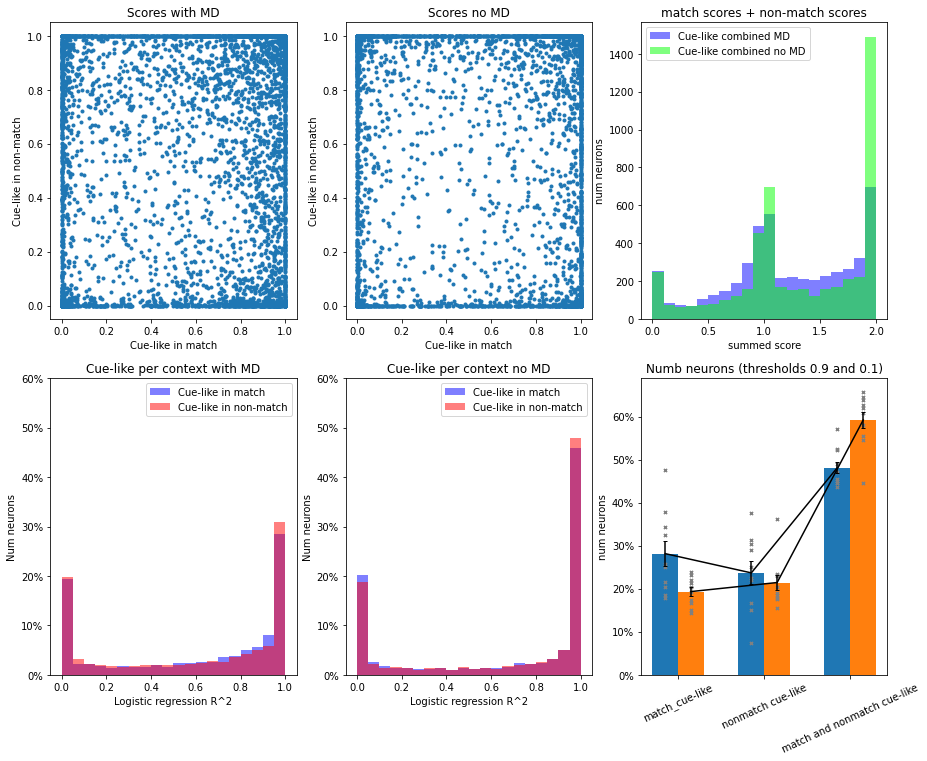

In [7]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D, "perc-cue")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


Text(0.5, 1.0, 'Num neurons (thresholds 0.9 and 0.1)')

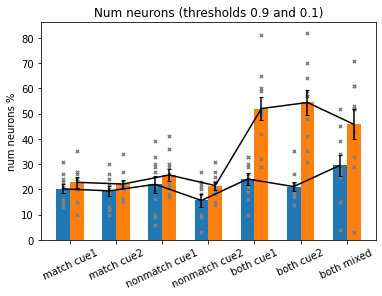

In [8]:
N_PFC_NEURONS = 500
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
                        
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D, "number")
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     

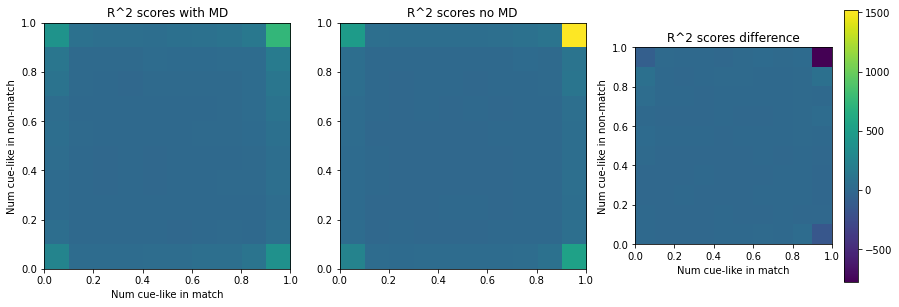

In [9]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

In [10]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)


(3000, 2)
(4000, 72)


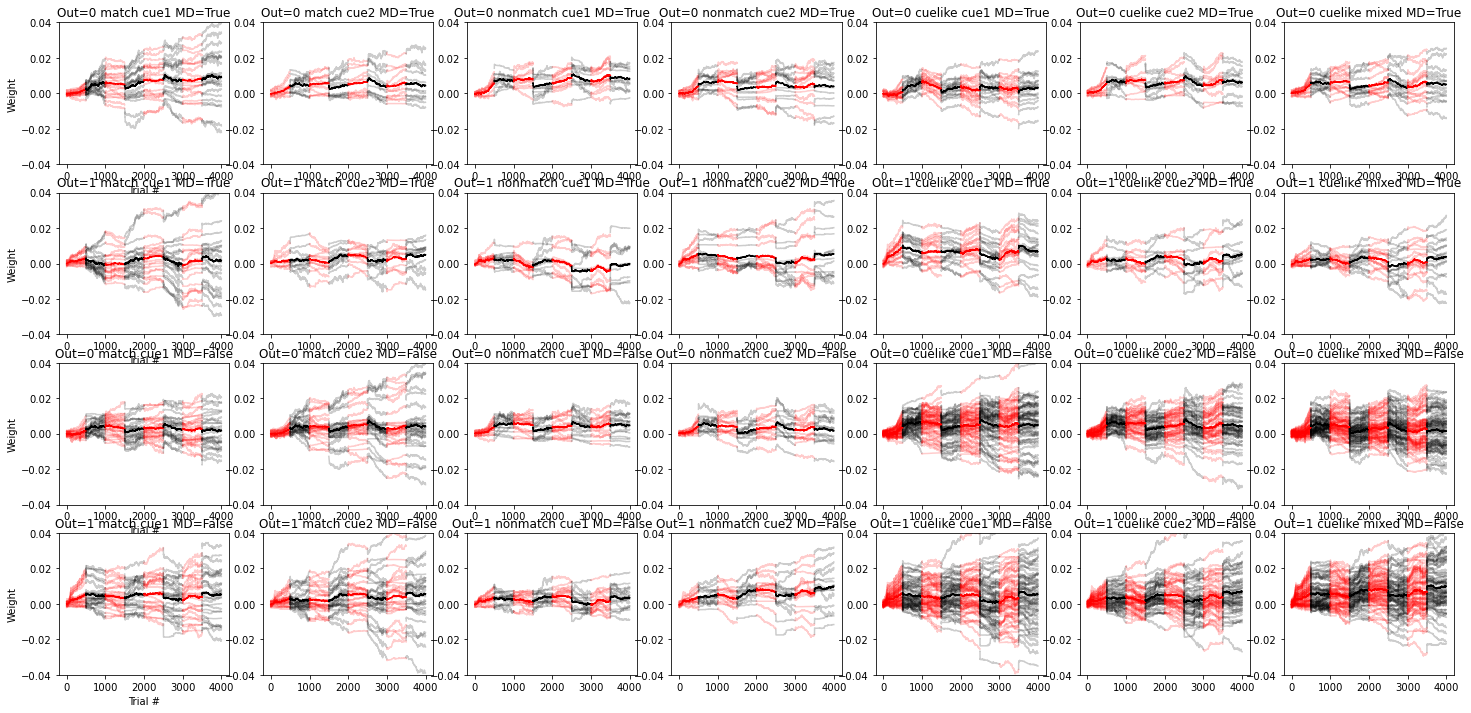

In [13]:
# IGNORE THIS CELL -- I FORGET WHAT'S GOING ON HERE

def plot_weights(run_idx, scores, wPFC_output, scores_noMD, wPFC_output_noMD):
    cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
    cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
    cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
    cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
    cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
    cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

    x = np.arange(0,4000)
    wPFC_out0_all = wPFC_output[match_trials,0,:]
    wPFC_out1_all = wPFC_output[match_trials,1,:]
    wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
    wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

    m0 = np.mean(wPFC_out0_all,1)
    m1 = np.mean(wPFC_out1_all,1)
    e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
    e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

    m0_noMD = np.mean(wPFC_out0_all_noMD,1)
    m1_noMD = np.mean(wPFC_out1_all_noMD,1)
    e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
    e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

    wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons[run_idx]]
    wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons[run_idx]]
    wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]]
    wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons[run_idx]]
    wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons[run_idx]]

    wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons[run_idx]]
    wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons[run_idx]]
    wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]]
    wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons[run_idx]]
    wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons[run_idx]]

    wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]]
    wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]]

    wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]]
    wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]]

    def plt_trials(ax, w):
        if w.shape[1] == 0:
            return

        match_blocks = [1,3,5,7]
        nmatch_blocks = [0,2,4,6]

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            m = np.mean(w[s:t,:],1)
            e = np.std(w[s:t,:],1)        
            ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#             ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    plt_trials(ax1,wPFC_out0_match_cue1_MD)
    ax1.set_ylim((-0.04,0.04))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    plt_trials(ax2,wPFC_out0_match_cue2_MD)
    ax2.set_ylim((-0.04,0.04))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
    ax3.set_ylim((-0.04,0.04))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
    ax4.set_ylim((-0.04,0.04))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
    ax5.set_ylim((-0.04,0.04))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
    ax6.set_ylim((-0.04,0.04))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
    ax7.set_ylim((-0.04,0.04))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    plt_trials(ax8,wPFC_out1_match_cue1_MD)
    ax8.set_ylim((-0.04,0.04))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    plt_trials(ax9,wPFC_out1_match_cue2_MD)
    ax9.set_ylim((-0.04,0.04))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
    ax10.set_ylim((-0.04,0.04))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
    ax11.set_ylim((-0.04,0.04))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
    ax12.set_ylim((-0.04,0.04))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
    ax13.set_ylim((-0.04,0.04))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
    ax14.set_ylim((-0.04,0.04))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    plt_trials(ax15,wPFC_out0_match_cue1_noMD)
    ax15.set_ylim((-0.04,0.04))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    plt_trials(ax16,wPFC_out0_match_cue2_noMD)
    ax16.set_ylim((-0.04,0.04))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
    ax17.set_ylim((-0.04,0.04))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
    ax18.set_ylim((-0.04,0.04))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
    ax19.set_ylim((-0.04,0.04))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
    ax20.set_ylim((-0.04,0.04))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
    ax21.set_ylim((-0.04,0.04))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    plt_trials(ax22,wPFC_out1_match_cue1_noMD)
    ax22.set_ylim((-0.04,0.04))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    plt_trials(ax23,wPFC_out1_match_cue2_noMD)
    ax23.set_ylim((-0.04,0.04))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
    ax24.set_ylim((-0.04,0.04))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
    ax25.set_ylim((-0.04,0.04))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
    ax26.set_ylim((-0.04,0.04))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
    ax27.set_ylim((-0.04,0.04))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
    ax28.set_ylim((-0.04,0.04))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    print(wPFC_out1_cuelike_mixed_noMD.shape)

    plt.show()

    
(_, _, _, wPFC_output) = load_obj(RUNS_MD[5])
(_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[5])
plot_weights(5, scores[2500:3000], wPFC_output, scores_noMD[2500:3000], wPFC_output_noMD)

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


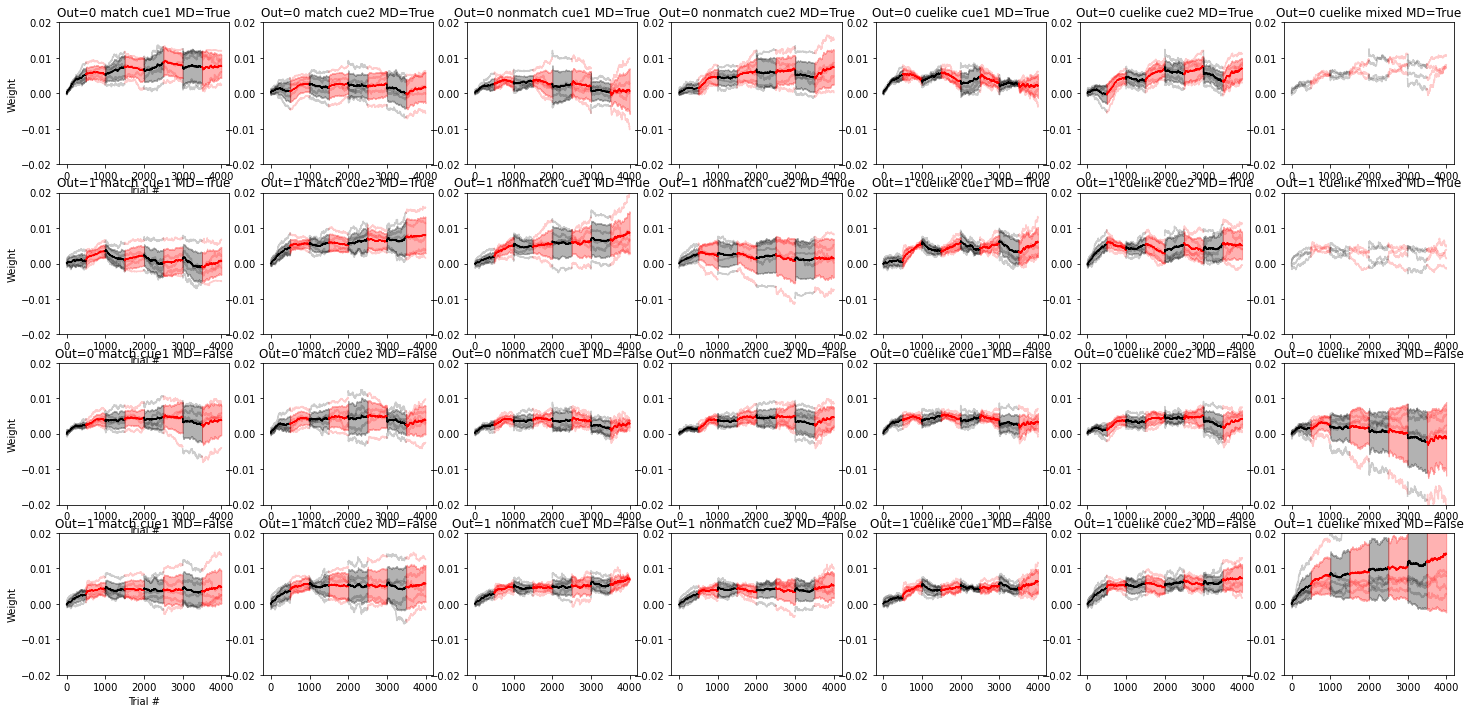

In [27]:
def plt_trials(ax, w, starts_with_match=True):
    if w.shape[1] == 0:
        return

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)
        c = 'k' if c == 'r' else 'r'

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
        ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)
        c = 'k' if c == 'r' else 'r'

def plot_weights(scores_, scores_noMD_):
    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    ax1.set_ylim((-0.02,0.02))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    ax2.set_ylim((-0.02,0.02))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    ax3.set_ylim((-0.02,0.02))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    ax4.set_ylim((-0.02,0.02))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    ax5.set_ylim((-0.02,0.02))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    ax6.set_ylim((-0.02,0.02))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    ax7.set_ylim((-0.02,0.02))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    ax8.set_ylim((-0.02,0.02))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    ax9.set_ylim((-0.02,0.02))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    ax10.set_ylim((-0.02,0.02))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    ax11.set_ylim((-0.02,0.02))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    ax12.set_ylim((-0.02,0.02))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    ax13.set_ylim((-0.02,0.02))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    ax14.set_ylim((-0.02,0.02))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    ax15.set_ylim((-0.02,0.02))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    ax16.set_ylim((-0.02,0.02))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    ax17.set_ylim((-0.02,0.02))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    ax18.set_ylim((-0.02,0.02))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    ax19.set_ylim((-0.02,0.02))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    ax20.set_ylim((-0.02,0.02))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    ax21.set_ylim((-0.02,0.02))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    ax22.set_ylim((-0.02,0.02))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    ax23.set_ylim((-0.02,0.02))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    ax24.set_ylim((-0.02,0.02))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    ax25.set_ylim((-0.02,0.02))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    ax26.set_ylim((-0.02,0.02))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    ax27.set_ylim((-0.02,0.02))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    ax28.set_ylim((-0.02,0.02))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    N_TRIALS = 4000
    N_SIMS = 5
    wPFC_out0_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out0_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))
    
    for run_idx in range(0,5):
        i = run_idx #run_idx - 5
        s = run_idx * 500
        t = run_idx * 500 + 500
        scores = scores_[s:t]
        scores_noMD = scores_noMD_[s:t]
        (_, _, _, wPFC_output) = load_obj(RUNS_MD[run_idx])
        (_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[run_idx])
    
        cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
        cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
        cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
        cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
        cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
        cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

        x = np.arange(0,4000)
        wPFC_out0_all = wPFC_output[match_trials,0,:]
        wPFC_out1_all = wPFC_output[match_trials,1,:]
        wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
        wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

        m0 = np.mean(wPFC_out0_all,1)
        m1 = np.mean(wPFC_out1_all,1)
        e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
        e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

        m0_noMD = np.mean(wPFC_out0_all_noMD,1)
        m1_noMD = np.mean(wPFC_out1_all_noMD,1)
        e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
        e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

        wPFC_out0_match_cue1_MD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons[run_idx]],1)
        wPFC_out0_match_cue2_MD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out1_match_cue1_MD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons[run_idx]],1)
        wPFC_out1_match_cue2_MD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out0_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]],1)

        wPFC_out1_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]],1)


    plt_trials(ax1,wPFC_out0_match_cue1_MD)

    plt_trials(ax2,wPFC_out0_match_cue2_MD)

    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)

    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)

    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)

    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)

    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)

    plt_trials(ax8,wPFC_out1_match_cue1_MD)

    plt_trials(ax9,wPFC_out1_match_cue2_MD)

    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)

    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)

    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)

    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)

    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)

    plt_trials(ax15,wPFC_out0_match_cue1_noMD)

    plt_trials(ax16,wPFC_out0_match_cue2_noMD)

    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)

    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)

    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)

    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)

    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)

    plt_trials(ax22,wPFC_out1_match_cue1_noMD)

    plt_trials(ax23,wPFC_out1_match_cue2_noMD)

    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)

    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)

    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)

    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)

    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)

    plt.show()    

plot_weights(scores, scores_noMD)

# See if neurons are expected for cue category

## ... this can all be ignored now

[array([ 27,  29,  33,  62,  65,  67,  73,  74,  86,  87,  92, 100, 110,
       114, 116, 124, 127, 134, 135, 141, 145, 148, 149, 153, 154, 156,
       166, 171, 180, 209, 373, 425]), array([ 13,  29,  31,  40,  43,  47,  48,  54,  57,  59,  67,  69,  71,
        73,  81,  86,  90, 102, 114, 121, 136, 146, 152, 153, 156, 157,
       166, 168, 171, 180, 184, 185, 187, 196, 199, 250, 379, 387, 401,
       410, 414, 472, 485, 497]), array([ 22,  27,  54,  64,  70,  74,  78,  80,  98, 102, 124, 133, 134,
       136, 148, 161, 163, 184, 187, 193, 203, 209, 250, 340, 352, 373,
       387, 427, 489]), array([  1,   3,  13,  22,  23,  33,  35,  40,  48,  54,  60,  78,  80,
        86,  96, 100, 112, 114, 134, 135, 149, 153, 154, 156, 161, 163,
       168, 190, 193, 194, 209, 223, 227, 340, 342, 467, 494]), array([ 11,  33,  73,  74, 129, 141, 153, 154, 174, 179, 185, 342, 352,
       379]), array([  3,  11,  12,  22,  27,  29,  45,  64,  66,  71,  73,  74,  96,
        99, 110, 133, 135, 136, 

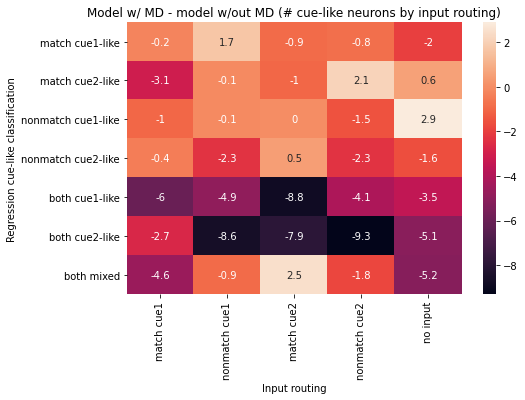

In [52]:
def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<ipython-input-25-f1dfce12a37f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(match_cue1_neurons).shape)


(10,)
[[ 5 10  7  3  6]
 [ 3  2  7  8  4]
 [ 1  2  0  0  3]
 [ 1  1  0  0  1]
 [ 3  1  2  4  0]
 [ 3  0  6  8  2]
 [ 6  5  9  3  3]]
[5, 3, 1, 1, 3, 3, 6]
[10, 2, 2, 1, 1, 0, 5]


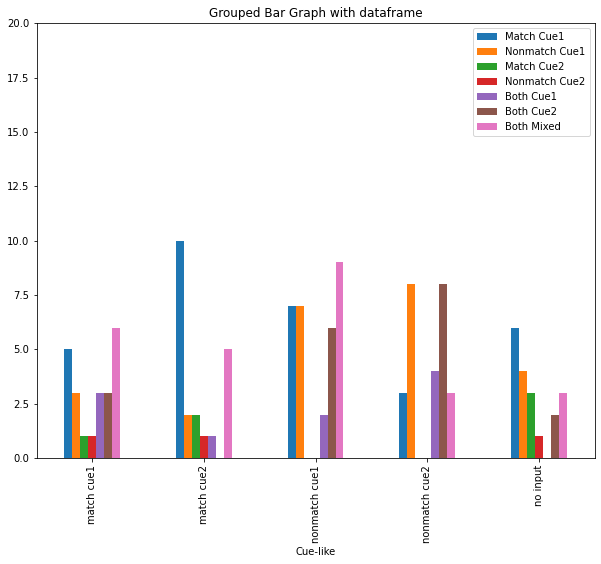

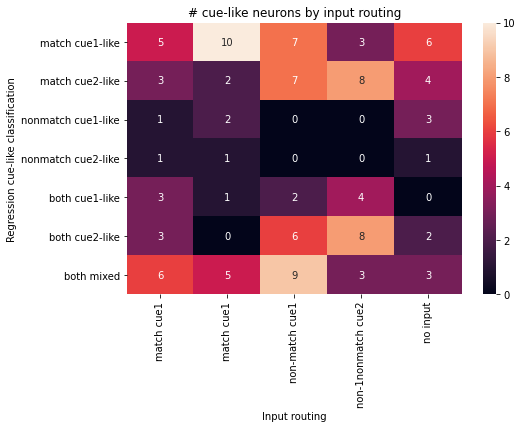

In [25]:
import pandas as pd
from operator import add

print(np.array(match_cue1_neurons).shape)

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 8
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
D_0_100 = ["match cue1"] + get_plot_data(0,100)
D_100_200 = ["match cue2"] + get_plot_data(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
D_400_500 = ["no input"] + get_plot_data(400,500)

# D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
# D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
# D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,20))

D_match_cue1 = get_plot_data(0,100)
D_match_cue2 = get_plot_data(100,200)
D_nonmatch_cue1 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_match_cue2, D_nonmatch_cue1, D_nonmatch_cue2, D_noinput]))

print(F)
print(D_match_cue1)
print(D_match_cue2)

cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'match cue1', 'non-match cue1', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

In [27]:
# Produce difference matrix plot (take mean over each initalization)

1

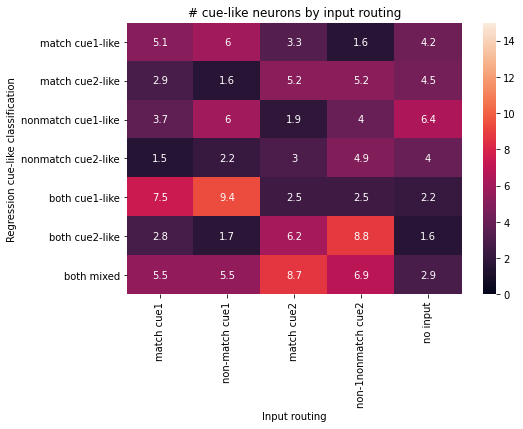

<AxesSubplot:title={'center':'Grouped Bar Graph with dataframe'}>

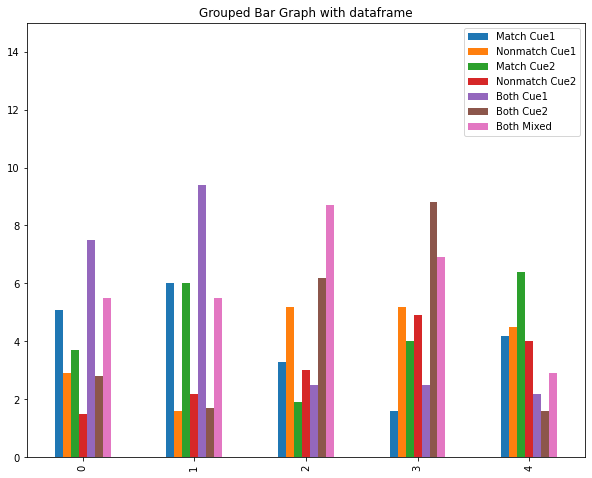

In [47]:
import pandas as pd
from operator import add

def get_plot_group(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data(0,100)
D_nonmatch_cue1 = get_plot_data(100,200)
D_match_cue2 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()


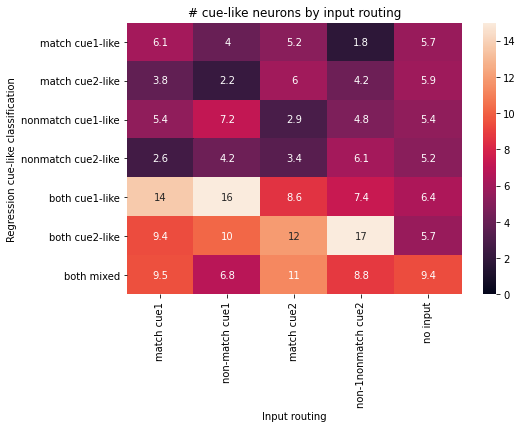

<AxesSubplot:title={'center':'Grouped Bar Graph with dataframe'}>

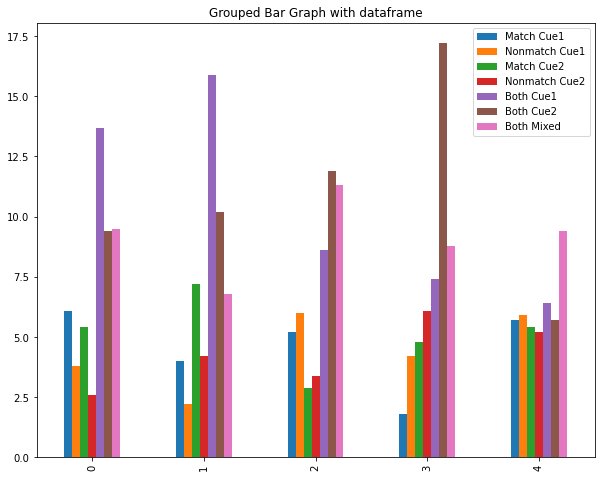

In [48]:
import pandas as pd
from operator import add

def get_plot_group_noMD(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group_noMD(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data_noMD(0,100)
D_nonmatch_cue1 = get_plot_data_noMD(100,200)
D_match_cue2 = get_plot_data_noMD(200,300)
D_nonmatch_cue2 = get_plot_data_noMD(300,400)
D_noinput = get_plot_data_noMD(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

